# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [4]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [ 0.01317684 -0.23364403  0.01789839  0.31985257] 0 1.0 False {}
state, action, reward, done, info: [ 0.00850396 -0.03878149  0.02429544  0.03286743] 1 1.0 False {}
state, action, reward, done, info: [ 0.00772833  0.15598378  0.02495279 -0.25205211] 1 1.0 False {}
state, action, reward, done, info: [ 0.010848   -0.03948543  0.01991175  0.0483958 ] 0 1.0 False {}
state, action, reward, done, info: [ 0.0100583   0.15534543  0.02087966 -0.23793889] 1 1.0 False {}
state, action, reward, done, info: [ 0.0131652   0.35016296  0.01612088 -0.52396332] 1 1.0 False {}
state, action, reward, done, info: [ 0.02016846  0.54505437  0.00564162 -0.81152311] 1 1.0 False {}
state, action, reward, done, info: [ 0.03106955  0.74009858 -0.01058884 -1.10242615] 1 1.0 False {}
state, action, reward, done, info: [ 0.04587152  0.93535822 -0.03263737 -1.39841225] 1 1.0 False {}
state, action, reward, done, info: [ 0.06457869  1.13087042 -0.06060561 -1.70111805] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [16]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    labelQs = tf.placeholder(tf.float32, [None], name='labelQs')
    return actions, states, targetQs, labelQs

In [17]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [32]:
def model_loss(action_size, hidden_size, states, actions, targetQs, labelQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    lossQtgt = tf.reduce_mean(tf.square(Qs - targetQs)) # next state, next action and nextQs
    lossQlbl = tf.reduce_mean(tf.square(Qs - labelQs)) # current state, action, and currentQs
    # lossQtgt_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
    #                                                                        labels=tf.nn.sigmoid(targetQs)))
    # lossQlbl_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs,
    #                                                                        labels=tf.nn.sigmoid(labelQs)))
    loss = lossQtgt + lossQlbl #+ lossQtgt_sigm + lossQlbl_sigm
    return actions_logits, loss, lossQtgt, lossQlbl

In [33]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [34]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.labelQs = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss, self.lossQtgt, self.lossQlbl = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, labelQs=self.labelQs)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [35]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [36]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [37]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [38]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [39]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [40]:
memory.buffer[0]

[array([-0.02798324, -0.02948733,  0.01148243, -0.01523122]),
 1,
 array([-0.02857298,  0.16546808,  0.01117781, -0.3042693 ]),
 1.0,
 0.0]

In [41]:
# states, rewards, actions

In [43]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Testing
            action_logits = sess.run(model.actions_logits, feed_dict = {model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: states})
            labelQs = np.max(actions_logits, axis=1) # explore
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            loss, _, lossQlbl, lossQtgt = sess.run([model.loss, model.opt, model.lossQlbl, model.lossQtgt], 
                                                   feed_dict = {model.states: states,
                                                                model.actions: actions,
                                                                model.targetQs: targetQs,
                                                                model.labelQs: labelQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model5.ckpt')

Episode: 0 meanReward: 10.0000 meanLoss: 1.3356
Episode: 1 meanReward: 10.0000 meanLoss: 1.9251
Episode: 2 meanReward: 9.3333 meanLoss: 2.6823
Episode: 3 meanReward: 9.5000 meanLoss: 4.3664
Episode: 4 meanReward: 9.6000 meanLoss: 7.8865
Episode: 5 meanReward: 9.3333 meanLoss: 9.6882
Episode: 6 meanReward: 9.2857 meanLoss: 8.4829
Episode: 7 meanReward: 9.2500 meanLoss: 6.9393
Episode: 8 meanReward: 9.3333 meanLoss: 4.7404
Episode: 9 meanReward: 9.4000 meanLoss: 2.8284
Episode: 10 meanReward: 9.4545 meanLoss: 1.5039
Episode: 11 meanReward: 9.4167 meanLoss: 0.4788
Episode: 12 meanReward: 9.3846 meanLoss: 0.1064
Episode: 13 meanReward: 9.5000 meanLoss: 0.4145
Episode: 14 meanReward: 9.5333 meanLoss: 1.3311
Episode: 15 meanReward: 9.8125 meanLoss: 2.6349
Episode: 16 meanReward: 10.0000 meanLoss: 1.2052
Episode: 17 meanReward: 10.1111 meanLoss: 1.6110
Episode: 18 meanReward: 10.1053 meanLoss: 4.0876
Episode: 19 meanReward: 10.1500 meanLoss: 12.6177
Episode: 20 meanReward: 10.1905 meanLoss: 2

Episode: 173 meanReward: 9.7188 meanLoss: 0.0579
Episode: 174 meanReward: 9.7188 meanLoss: 0.0734
Episode: 175 meanReward: 9.7188 meanLoss: 0.0858
Episode: 176 meanReward: 9.6875 meanLoss: 0.0831
Episode: 177 meanReward: 9.6562 meanLoss: 0.1492
Episode: 178 meanReward: 9.6875 meanLoss: 0.3584
Episode: 179 meanReward: 9.6875 meanLoss: 0.5149
Episode: 180 meanReward: 9.6875 meanLoss: 0.1941
Episode: 181 meanReward: 9.6875 meanLoss: 0.1151
Episode: 182 meanReward: 9.6875 meanLoss: 0.1374
Episode: 183 meanReward: 9.6250 meanLoss: 0.1142
Episode: 184 meanReward: 9.5938 meanLoss: 0.1790
Episode: 185 meanReward: 9.5312 meanLoss: 0.3523
Episode: 186 meanReward: 9.5000 meanLoss: 0.5337
Episode: 187 meanReward: 9.5312 meanLoss: 0.3422
Episode: 188 meanReward: 9.5625 meanLoss: 0.1650
Episode: 189 meanReward: 9.5938 meanLoss: 0.1945
Episode: 190 meanReward: 9.5625 meanLoss: 0.2850
Episode: 191 meanReward: 9.5625 meanLoss: 0.4425
Episode: 192 meanReward: 9.5625 meanLoss: 0.4770
Episode: 193 meanRew

Episode: 342 meanReward: 19.4688 meanLoss: 0.5560
Episode: 343 meanReward: 19.5625 meanLoss: 0.3399
Episode: 344 meanReward: 20.2188 meanLoss: 0.4950
Episode: 345 meanReward: 21.1562 meanLoss: 0.5652
Episode: 346 meanReward: 21.7188 meanLoss: 1.0414
Episode: 347 meanReward: 22.5625 meanLoss: 1.3368
Episode: 348 meanReward: 23.6250 meanLoss: 1.1145
Episode: 349 meanReward: 24.8438 meanLoss: 0.9540
Episode: 350 meanReward: 24.7812 meanLoss: 1.4731
Episode: 351 meanReward: 25.5000 meanLoss: 0.6568
Episode: 352 meanReward: 29.2500 meanLoss: 3.2040
Episode: 353 meanReward: 29.6562 meanLoss: 8.2118
Episode: 354 meanReward: 32.5625 meanLoss: 9.3398
Episode: 355 meanReward: 36.9062 meanLoss: 53.2631
Episode: 356 meanReward: 36.7500 meanLoss: 2364.8015
Episode: 357 meanReward: 36.6875 meanLoss: 2893.9006
Episode: 358 meanReward: 36.7188 meanLoss: 1679.7695
Episode: 359 meanReward: 36.8125 meanLoss: 276.9999
Episode: 360 meanReward: 37.3125 meanLoss: 96.7212
Episode: 361 meanReward: 37.3125 mean

Episode: 495 meanReward: 211.5312 meanLoss: 32882.1406
Episode: 496 meanReward: 212.9062 meanLoss: 26972.2734
Episode: 497 meanReward: 211.0625 meanLoss: 34103.3242
Episode: 498 meanReward: 211.7500 meanLoss: 28977.3828
Episode: 499 meanReward: 211.4062 meanLoss: 33756.7383
Episode: 500 meanReward: 209.2812 meanLoss: 31179.1211
Episode: 501 meanReward: 209.4375 meanLoss: 33581.3320
Episode: 502 meanReward: 210.4688 meanLoss: 29425.5469
Episode: 503 meanReward: 210.9688 meanLoss: 28731.0312
Episode: 504 meanReward: 210.8750 meanLoss: 35471.9023
Episode: 505 meanReward: 210.5000 meanLoss: 33826.4336
Episode: 506 meanReward: 212.4375 meanLoss: 24869.0039
Episode: 507 meanReward: 210.3750 meanLoss: 33116.1250
Episode: 508 meanReward: 210.1562 meanLoss: 29249.7969
Episode: 509 meanReward: 209.6875 meanLoss: 35083.1094
Episode: 510 meanReward: 208.8438 meanLoss: 29219.6602
Episode: 511 meanReward: 210.0000 meanLoss: 28892.8418
Episode: 512 meanReward: 209.3125 meanLoss: 31208.8535
Episode: 5

Episode: 644 meanReward: 215.0000 meanLoss: 32813.3984
Episode: 645 meanReward: 215.4375 meanLoss: 28551.6973
Episode: 646 meanReward: 213.7188 meanLoss: 32488.8242
Episode: 647 meanReward: 213.0938 meanLoss: 32302.8359
Episode: 648 meanReward: 213.3438 meanLoss: 27946.0508
Episode: 649 meanReward: 213.1875 meanLoss: 33697.6797
Episode: 650 meanReward: 213.4375 meanLoss: 30912.5332
Episode: 651 meanReward: 211.0625 meanLoss: 33725.4375
Episode: 652 meanReward: 210.3125 meanLoss: 32967.1992
Episode: 653 meanReward: 209.0312 meanLoss: 34803.6055
Episode: 654 meanReward: 209.2188 meanLoss: 33543.2773
Episode: 655 meanReward: 209.4688 meanLoss: 28142.0508
Episode: 656 meanReward: 209.0000 meanLoss: 30733.3223
Episode: 657 meanReward: 209.0000 meanLoss: 33229.7344
Episode: 658 meanReward: 209.0000 meanLoss: 32485.0430
Episode: 659 meanReward: 208.3438 meanLoss: 33641.9883
Episode: 660 meanReward: 207.7188 meanLoss: 32648.2227
Episode: 661 meanReward: 207.2812 meanLoss: 32348.2734
Episode: 6

Episode: 793 meanReward: 212.2500 meanLoss: 32145.9570
Episode: 794 meanReward: 213.1250 meanLoss: 28936.9355
Episode: 795 meanReward: 213.8750 meanLoss: 31340.1445
Episode: 796 meanReward: 212.9688 meanLoss: 33353.3008
Episode: 797 meanReward: 213.0625 meanLoss: 32470.6328
Episode: 798 meanReward: 214.0625 meanLoss: 29666.7949
Episode: 799 meanReward: 214.6875 meanLoss: 28525.6309
Episode: 800 meanReward: 213.7188 meanLoss: 32044.3750
Episode: 801 meanReward: 214.1250 meanLoss: 26938.8906
Episode: 802 meanReward: 215.1250 meanLoss: 31254.3984
Episode: 803 meanReward: 213.6875 meanLoss: 33990.5273
Episode: 804 meanReward: 212.6875 meanLoss: 27250.7871
Episode: 805 meanReward: 213.5625 meanLoss: 27236.6211
Episode: 806 meanReward: 213.8125 meanLoss: 29630.2227
Episode: 807 meanReward: 213.1250 meanLoss: 30528.2383
Episode: 808 meanReward: 213.3750 meanLoss: 31752.4023
Episode: 809 meanReward: 213.0000 meanLoss: 33384.2500
Episode: 810 meanReward: 213.5000 meanLoss: 31275.4727
Episode: 8

Episode: 942 meanReward: 208.9062 meanLoss: 35977.8828
Episode: 943 meanReward: 209.2188 meanLoss: 31088.3613
Episode: 944 meanReward: 209.9062 meanLoss: 27982.0547
Episode: 945 meanReward: 210.2812 meanLoss: 29833.8086
Episode: 946 meanReward: 210.4062 meanLoss: 31809.2344
Episode: 947 meanReward: 211.6562 meanLoss: 28964.6953
Episode: 948 meanReward: 211.2500 meanLoss: 31347.3047
Episode: 949 meanReward: 209.8125 meanLoss: 34517.0547
Episode: 950 meanReward: 210.5000 meanLoss: 29852.1191
Episode: 951 meanReward: 211.3438 meanLoss: 29381.6777
Episode: 952 meanReward: 210.7188 meanLoss: 33677.6328
Episode: 953 meanReward: 211.0312 meanLoss: 29401.5508
Episode: 954 meanReward: 210.9062 meanLoss: 26841.9785
Episode: 955 meanReward: 210.7500 meanLoss: 33078.4648
Episode: 956 meanReward: 210.3125 meanLoss: 31985.2988
Episode: 957 meanReward: 209.3125 meanLoss: 31065.3906
Episode: 958 meanReward: 209.7500 meanLoss: 28796.6172
Episode: 959 meanReward: 210.7188 meanLoss: 30429.6875
Episode: 9

Episode: 1090 meanReward: 215.7188 meanLoss: 33642.2539
Episode: 1091 meanReward: 216.5938 meanLoss: 29204.3477
Episode: 1092 meanReward: 216.5938 meanLoss: 31836.4043
Episode: 1093 meanReward: 216.7188 meanLoss: 32513.0449
Episode: 1094 meanReward: 218.7500 meanLoss: 24670.0234
Episode: 1095 meanReward: 218.7188 meanLoss: 29000.3691
Episode: 1096 meanReward: 218.4062 meanLoss: 29643.8555
Episode: 1097 meanReward: 219.1562 meanLoss: 28744.4590
Episode: 1098 meanReward: 218.6875 meanLoss: 33732.5156
Episode: 1099 meanReward: 216.6562 meanLoss: 34072.9961
Episode: 1100 meanReward: 218.3750 meanLoss: 23787.7383
Episode: 1101 meanReward: 219.0625 meanLoss: 32179.6543
Episode: 1102 meanReward: 220.3750 meanLoss: 27807.4355
Episode: 1103 meanReward: 220.7812 meanLoss: 30837.0996
Episode: 1104 meanReward: 218.7812 meanLoss: 33240.5586
Episode: 1105 meanReward: 218.1875 meanLoss: 33085.6797
Episode: 1106 meanReward: 213.0938 meanLoss: 36050.0000
Episode: 1107 meanReward: 212.5625 meanLoss: 347

Episode: 1237 meanReward: 214.2500 meanLoss: 31265.0078
Episode: 1238 meanReward: 212.6875 meanLoss: 32968.4141
Episode: 1239 meanReward: 212.3438 meanLoss: 34883.1914
Episode: 1240 meanReward: 211.1875 meanLoss: 33550.1484
Episode: 1241 meanReward: 210.9375 meanLoss: 28403.3906
Episode: 1242 meanReward: 211.7500 meanLoss: 28065.9688
Episode: 1243 meanReward: 212.0938 meanLoss: 31516.8242
Episode: 1244 meanReward: 212.1875 meanLoss: 30004.6504
Episode: 1245 meanReward: 212.8125 meanLoss: 31215.5820
Episode: 1246 meanReward: 213.0000 meanLoss: 32754.9941
Episode: 1247 meanReward: 212.6562 meanLoss: 29042.7090
Episode: 1248 meanReward: 212.0625 meanLoss: 32506.8223
Episode: 1249 meanReward: 212.3438 meanLoss: 30546.5508
Episode: 1250 meanReward: 210.8750 meanLoss: 33007.3594
Episode: 1251 meanReward: 209.6562 meanLoss: 35219.3789
Episode: 1252 meanReward: 209.3438 meanLoss: 31546.7480
Episode: 1253 meanReward: 208.5625 meanLoss: 33292.1562
Episode: 1254 meanReward: 208.5312 meanLoss: 323

Episode: 1384 meanReward: 205.4375 meanLoss: 32464.5840
Episode: 1385 meanReward: 202.9375 meanLoss: 29131.1133
Episode: 1386 meanReward: 203.2812 meanLoss: 30234.0664
Episode: 1387 meanReward: 203.8750 meanLoss: 29359.2695
Episode: 1388 meanReward: 204.2500 meanLoss: 29990.9746
Episode: 1389 meanReward: 203.9688 meanLoss: 34897.4727
Episode: 1390 meanReward: 204.7500 meanLoss: 31505.3457
Episode: 1391 meanReward: 204.3125 meanLoss: 35415.4688
Episode: 1392 meanReward: 203.4688 meanLoss: 33399.9180
Episode: 1393 meanReward: 204.5938 meanLoss: 27234.4395
Episode: 1394 meanReward: 204.6250 meanLoss: 31722.4355
Episode: 1395 meanReward: 205.0000 meanLoss: 33720.0742
Episode: 1396 meanReward: 206.1875 meanLoss: 28745.3379
Episode: 1397 meanReward: 206.3438 meanLoss: 29089.1758
Episode: 1398 meanReward: 206.5312 meanLoss: 28135.0547
Episode: 1399 meanReward: 205.7188 meanLoss: 34148.5664
Episode: 1400 meanReward: 204.6562 meanLoss: 32667.7598
Episode: 1401 meanReward: 203.9688 meanLoss: 351

Episode: 1531 meanReward: 214.8125 meanLoss: 30149.1934
Episode: 1532 meanReward: 213.0938 meanLoss: 33225.0000
Episode: 1533 meanReward: 213.2188 meanLoss: 33147.7227
Episode: 1534 meanReward: 213.2812 meanLoss: 31035.0312
Episode: 1535 meanReward: 213.8125 meanLoss: 28451.2227
Episode: 1536 meanReward: 214.0625 meanLoss: 29911.1387
Episode: 1537 meanReward: 213.7500 meanLoss: 31406.9297
Episode: 1538 meanReward: 214.2812 meanLoss: 32953.5039
Episode: 1539 meanReward: 215.9375 meanLoss: 25538.9219
Episode: 1540 meanReward: 216.1875 meanLoss: 27247.2207
Episode: 1541 meanReward: 216.5938 meanLoss: 26326.3613
Episode: 1542 meanReward: 215.5625 meanLoss: 31780.3164
Episode: 1543 meanReward: 215.4375 meanLoss: 32708.2988
Episode: 1544 meanReward: 215.6562 meanLoss: 32837.4414
Episode: 1545 meanReward: 216.1250 meanLoss: 32318.7988
Episode: 1546 meanReward: 215.5000 meanLoss: 29394.5820
Episode: 1547 meanReward: 215.6250 meanLoss: 31188.6270
Episode: 1548 meanReward: 216.2812 meanLoss: 291

Episode: 1678 meanReward: 211.1562 meanLoss: 33844.3633
Episode: 1679 meanReward: 210.5625 meanLoss: 32767.2246
Episode: 1680 meanReward: 208.7812 meanLoss: 32780.3594
Episode: 1681 meanReward: 209.1875 meanLoss: 30572.4883
Episode: 1682 meanReward: 208.8438 meanLoss: 33382.7773
Episode: 1683 meanReward: 208.9375 meanLoss: 30269.5117
Episode: 1684 meanReward: 208.4688 meanLoss: 30487.3848
Episode: 1685 meanReward: 210.9062 meanLoss: 25091.9727
Episode: 1686 meanReward: 212.0938 meanLoss: 26030.4883
Episode: 1687 meanReward: 212.6250 meanLoss: 30213.6914
Episode: 1688 meanReward: 213.7812 meanLoss: 28271.7285
Episode: 1689 meanReward: 213.2188 meanLoss: 32912.3438
Episode: 1690 meanReward: 212.3438 meanLoss: 28066.6836
Episode: 1691 meanReward: 212.3125 meanLoss: 30575.1445
Episode: 1692 meanReward: 211.6562 meanLoss: 33201.2500
Episode: 1693 meanReward: 212.7188 meanLoss: 29643.6211
Episode: 1694 meanReward: 213.5000 meanLoss: 28780.9727
Episode: 1695 meanReward: 215.1875 meanLoss: 271

Episode: 1825 meanReward: 211.3125 meanLoss: 33535.0664
Episode: 1826 meanReward: 210.6250 meanLoss: 32164.1406
Episode: 1827 meanReward: 212.8750 meanLoss: 23968.8281
Episode: 1828 meanReward: 212.6250 meanLoss: 32524.8203
Episode: 1829 meanReward: 214.8125 meanLoss: 26043.9941
Episode: 1830 meanReward: 214.9688 meanLoss: 35194.0586
Episode: 1831 meanReward: 214.1562 meanLoss: 28350.8613
Episode: 1832 meanReward: 214.6250 meanLoss: 29594.8242
Episode: 1833 meanReward: 216.1875 meanLoss: 28315.9609
Episode: 1834 meanReward: 214.6250 meanLoss: 33998.1641
Episode: 1835 meanReward: 216.4375 meanLoss: 27616.2656
Episode: 1836 meanReward: 216.1875 meanLoss: 32143.3125
Episode: 1837 meanReward: 215.0312 meanLoss: 33195.7305
Episode: 1838 meanReward: 214.7188 meanLoss: 33598.9883
Episode: 1839 meanReward: 213.3125 meanLoss: 31311.2480
Episode: 1840 meanReward: 211.7188 meanLoss: 33143.3242
Episode: 1841 meanReward: 212.7812 meanLoss: 30066.4531
Episode: 1842 meanReward: 213.0938 meanLoss: 319

Episode: 1972 meanReward: 215.3750 meanLoss: 30106.0820
Episode: 1973 meanReward: 215.2500 meanLoss: 27362.2949
Episode: 1974 meanReward: 216.9688 meanLoss: 25812.2383
Episode: 1975 meanReward: 218.6875 meanLoss: 25129.0078
Episode: 1976 meanReward: 218.1562 meanLoss: 33068.0312
Episode: 1977 meanReward: 220.1562 meanLoss: 24062.1270
Episode: 1978 meanReward: 220.1562 meanLoss: 32080.6016
Episode: 1979 meanReward: 219.2812 meanLoss: 35213.6758
Episode: 1980 meanReward: 218.4688 meanLoss: 33753.6992
Episode: 1981 meanReward: 217.7188 meanLoss: 32765.4629
Episode: 1982 meanReward: 217.5625 meanLoss: 35189.2656
Episode: 1983 meanReward: 216.8125 meanLoss: 28842.7715
Episode: 1984 meanReward: 217.0938 meanLoss: 28778.3789
Episode: 1985 meanReward: 213.5625 meanLoss: 28703.6133
Episode: 1986 meanReward: 213.2812 meanLoss: 32436.5977
Episode: 1987 meanReward: 213.9688 meanLoss: 29440.2754
Episode: 1988 meanReward: 214.1562 meanLoss: 32098.1484
Episode: 1989 meanReward: 214.3750 meanLoss: 307

Episode: 2119 meanReward: 206.1562 meanLoss: 31877.5020
Episode: 2120 meanReward: 206.6875 meanLoss: 29535.5234
Episode: 2121 meanReward: 206.8438 meanLoss: 34109.0273
Episode: 2122 meanReward: 208.4062 meanLoss: 27990.3027
Episode: 2123 meanReward: 209.5312 meanLoss: 27057.0781
Episode: 2124 meanReward: 209.6562 meanLoss: 31339.2988
Episode: 2125 meanReward: 209.2500 meanLoss: 30583.7520
Episode: 2126 meanReward: 208.9688 meanLoss: 29163.2852
Episode: 2127 meanReward: 208.8750 meanLoss: 30355.1680
Episode: 2128 meanReward: 208.7188 meanLoss: 35073.6055
Episode: 2129 meanReward: 209.1875 meanLoss: 28162.0215
Episode: 2130 meanReward: 207.4688 meanLoss: 35705.6172
Episode: 2131 meanReward: 208.5312 meanLoss: 28282.8105
Episode: 2132 meanReward: 209.0625 meanLoss: 25787.7754
Episode: 2133 meanReward: 208.4375 meanLoss: 31973.3242
Episode: 2134 meanReward: 209.0000 meanLoss: 30346.9434
Episode: 2135 meanReward: 210.3750 meanLoss: 26854.5664
Episode: 2136 meanReward: 210.1875 meanLoss: 316

Episode: 2266 meanReward: 212.7500 meanLoss: 28708.5781
Episode: 2267 meanReward: 213.4062 meanLoss: 29418.5117
Episode: 2268 meanReward: 214.1562 meanLoss: 29552.8203
Episode: 2269 meanReward: 214.5312 meanLoss: 28199.5762
Episode: 2270 meanReward: 214.2812 meanLoss: 31072.0645
Episode: 2271 meanReward: 213.8750 meanLoss: 28092.8496
Episode: 2272 meanReward: 213.7188 meanLoss: 29669.8320
Episode: 2273 meanReward: 214.7188 meanLoss: 27660.2832
Episode: 2274 meanReward: 214.3750 meanLoss: 33678.1641
Episode: 2275 meanReward: 214.3750 meanLoss: 33449.9258
Episode: 2276 meanReward: 214.1875 meanLoss: 35193.4805
Episode: 2277 meanReward: 215.9375 meanLoss: 25623.9219
Episode: 2278 meanReward: 214.5625 meanLoss: 34570.8359
Episode: 2279 meanReward: 214.9062 meanLoss: 31415.5117
Episode: 2280 meanReward: 213.8438 meanLoss: 30945.0645
Episode: 2281 meanReward: 212.6875 meanLoss: 32427.6426
Episode: 2282 meanReward: 214.5938 meanLoss: 26392.5176
Episode: 2283 meanReward: 214.4688 meanLoss: 303

Episode: 2413 meanReward: 210.7812 meanLoss: 35715.6875
Episode: 2414 meanReward: 208.5000 meanLoss: 34420.5391
Episode: 2415 meanReward: 208.3438 meanLoss: 32610.6094
Episode: 2416 meanReward: 209.2500 meanLoss: 25392.9746
Episode: 2417 meanReward: 210.1250 meanLoss: 28857.1855
Episode: 2418 meanReward: 209.5000 meanLoss: 33565.7031
Episode: 2419 meanReward: 210.5000 meanLoss: 28646.6016
Episode: 2420 meanReward: 210.9062 meanLoss: 30314.7285
Episode: 2421 meanReward: 212.0000 meanLoss: 28724.9160
Episode: 2422 meanReward: 211.7188 meanLoss: 33405.6328
Episode: 2423 meanReward: 212.5625 meanLoss: 25253.5078
Episode: 2424 meanReward: 214.1562 meanLoss: 26996.4434
Episode: 2425 meanReward: 213.3750 meanLoss: 33548.1797
Episode: 2426 meanReward: 213.2188 meanLoss: 29222.3496
Episode: 2427 meanReward: 212.9062 meanLoss: 32517.3652
Episode: 2428 meanReward: 212.7500 meanLoss: 30219.7852
Episode: 2429 meanReward: 213.5312 meanLoss: 25760.4980
Episode: 2430 meanReward: 212.0000 meanLoss: 343

Episode: 2560 meanReward: 207.6250 meanLoss: 32240.2266
Episode: 2561 meanReward: 208.3438 meanLoss: 28740.1465
Episode: 2562 meanReward: 208.4062 meanLoss: 30427.4102
Episode: 2563 meanReward: 207.8438 meanLoss: 32663.8398
Episode: 2564 meanReward: 208.4688 meanLoss: 28505.9766
Episode: 2565 meanReward: 208.7500 meanLoss: 31447.3867
Episode: 2566 meanReward: 207.0938 meanLoss: 31748.7910
Episode: 2567 meanReward: 206.8750 meanLoss: 28727.6406
Episode: 2568 meanReward: 206.2500 meanLoss: 31873.8691
Episode: 2569 meanReward: 204.3125 meanLoss: 34817.4570
Episode: 2570 meanReward: 204.6875 meanLoss: 30397.2480
Episode: 2571 meanReward: 204.9375 meanLoss: 33062.5352
Episode: 2572 meanReward: 204.2188 meanLoss: 31822.6562
Episode: 2573 meanReward: 202.9375 meanLoss: 34315.4219
Episode: 2574 meanReward: 204.2812 meanLoss: 25761.5586
Episode: 2575 meanReward: 204.4375 meanLoss: 31993.7480
Episode: 2576 meanReward: 203.8750 meanLoss: 35228.6250
Episode: 2577 meanReward: 207.3125 meanLoss: 209

Episode: 2707 meanReward: 218.4375 meanLoss: 33907.2227
Episode: 2708 meanReward: 217.9688 meanLoss: 29698.2090
Episode: 2709 meanReward: 217.3750 meanLoss: 33638.2773
Episode: 2710 meanReward: 217.4375 meanLoss: 29368.9629
Episode: 2711 meanReward: 216.0312 meanLoss: 31902.1172
Episode: 2712 meanReward: 211.8750 meanLoss: 33274.6562
Episode: 2713 meanReward: 211.8125 meanLoss: 33512.6641
Episode: 2714 meanReward: 213.2188 meanLoss: 26918.8242
Episode: 2715 meanReward: 214.0312 meanLoss: 28515.6914
Episode: 2716 meanReward: 215.1875 meanLoss: 29149.4102
Episode: 2717 meanReward: 214.5312 meanLoss: 33909.5430
Episode: 2718 meanReward: 213.0625 meanLoss: 34359.4023
Episode: 2719 meanReward: 213.7500 meanLoss: 28836.6738
Episode: 2720 meanReward: 214.6250 meanLoss: 28352.6465
Episode: 2721 meanReward: 216.1562 meanLoss: 25399.8008
Episode: 2722 meanReward: 214.3750 meanLoss: 32771.1367
Episode: 2723 meanReward: 213.9062 meanLoss: 36822.5352
Episode: 2724 meanReward: 213.0625 meanLoss: 297

Episode: 2854 meanReward: 208.8438 meanLoss: 32287.8477
Episode: 2855 meanReward: 208.6250 meanLoss: 29929.2480
Episode: 2856 meanReward: 208.6250 meanLoss: 32174.7578
Episode: 2857 meanReward: 209.1250 meanLoss: 32486.3574
Episode: 2858 meanReward: 208.4375 meanLoss: 35101.7500
Episode: 2859 meanReward: 208.2500 meanLoss: 33779.3086
Episode: 2860 meanReward: 208.0938 meanLoss: 32043.6016
Episode: 2861 meanReward: 207.4375 meanLoss: 33987.8125
Episode: 2862 meanReward: 205.8750 meanLoss: 33700.6523
Episode: 2863 meanReward: 206.1875 meanLoss: 28526.3945
Episode: 2864 meanReward: 206.6250 meanLoss: 30732.0352
Episode: 2865 meanReward: 206.7812 meanLoss: 33194.1016
Episode: 2866 meanReward: 206.0000 meanLoss: 34618.9102
Episode: 2867 meanReward: 206.6250 meanLoss: 27830.1426
Episode: 2868 meanReward: 206.0938 meanLoss: 30092.6387
Episode: 2869 meanReward: 207.7500 meanLoss: 22281.3652
Episode: 2870 meanReward: 208.5625 meanLoss: 31418.9023
Episode: 2871 meanReward: 208.5312 meanLoss: 344

Episode: 3001 meanReward: 213.9688 meanLoss: 32837.0938
Episode: 3002 meanReward: 213.1562 meanLoss: 31804.4609
Episode: 3003 meanReward: 212.5938 meanLoss: 32853.2500
Episode: 3004 meanReward: 214.1250 meanLoss: 27678.6777
Episode: 3005 meanReward: 214.4375 meanLoss: 31052.2656
Episode: 3006 meanReward: 213.8125 meanLoss: 31932.8047
Episode: 3007 meanReward: 215.0938 meanLoss: 26865.3477
Episode: 3008 meanReward: 215.4688 meanLoss: 31586.8496
Episode: 3009 meanReward: 216.1875 meanLoss: 30038.2344
Episode: 3010 meanReward: 215.9062 meanLoss: 32146.5078
Episode: 3011 meanReward: 213.1250 meanLoss: 30825.3184
Episode: 3012 meanReward: 213.3438 meanLoss: 33799.9258
Episode: 3013 meanReward: 213.2500 meanLoss: 33733.5938
Episode: 3014 meanReward: 213.7500 meanLoss: 31995.1152
Episode: 3015 meanReward: 213.5000 meanLoss: 31999.8027
Episode: 3016 meanReward: 212.2500 meanLoss: 33905.9648
Episode: 3017 meanReward: 214.6875 meanLoss: 22479.2266
Episode: 3018 meanReward: 215.3438 meanLoss: 323

Episode: 3148 meanReward: 214.8438 meanLoss: 30245.5098
Episode: 3149 meanReward: 214.6562 meanLoss: 30909.3477
Episode: 3150 meanReward: 214.9375 meanLoss: 30580.2461
Episode: 3151 meanReward: 215.5625 meanLoss: 32238.8809
Episode: 3152 meanReward: 215.1562 meanLoss: 32899.9570
Episode: 3153 meanReward: 215.6250 meanLoss: 30555.6953
Episode: 3154 meanReward: 214.8438 meanLoss: 32351.9414
Episode: 3155 meanReward: 214.0312 meanLoss: 30979.5117
Episode: 3156 meanReward: 214.6250 meanLoss: 29585.7520
Episode: 3157 meanReward: 216.3438 meanLoss: 26500.2637
Episode: 3158 meanReward: 215.2812 meanLoss: 32789.3984
Episode: 3159 meanReward: 214.4688 meanLoss: 35259.9492
Episode: 3160 meanReward: 212.7188 meanLoss: 34175.0859
Episode: 3161 meanReward: 210.5938 meanLoss: 32801.4180
Episode: 3162 meanReward: 209.5312 meanLoss: 37074.4961
Episode: 3163 meanReward: 210.9062 meanLoss: 27419.4043
Episode: 3164 meanReward: 211.3125 meanLoss: 31550.6973
Episode: 3165 meanReward: 212.1250 meanLoss: 295

Episode: 3295 meanReward: 214.9062 meanLoss: 34194.7695
Episode: 3296 meanReward: 215.4062 meanLoss: 30172.3789
Episode: 3297 meanReward: 214.6562 meanLoss: 28163.6211
Episode: 3298 meanReward: 213.0625 meanLoss: 30589.8809
Episode: 3299 meanReward: 214.5938 meanLoss: 24987.1777
Episode: 3300 meanReward: 215.0938 meanLoss: 30988.1973
Episode: 3301 meanReward: 216.3750 meanLoss: 27365.8867
Episode: 3302 meanReward: 215.2812 meanLoss: 32543.6191
Episode: 3303 meanReward: 214.5938 meanLoss: 34450.9258
Episode: 3304 meanReward: 214.5625 meanLoss: 30049.0371
Episode: 3305 meanReward: 215.1875 meanLoss: 30788.1191
Episode: 3306 meanReward: 214.7188 meanLoss: 34000.1133
Episode: 3307 meanReward: 215.8438 meanLoss: 28835.7578
Episode: 3308 meanReward: 213.9688 meanLoss: 26583.9922
Episode: 3309 meanReward: 211.7812 meanLoss: 34474.6836
Episode: 3310 meanReward: 212.6875 meanLoss: 28463.2305
Episode: 3311 meanReward: 212.2812 meanLoss: 31807.2480
Episode: 3312 meanReward: 212.5000 meanLoss: 300

Episode: 3442 meanReward: 221.3438 meanLoss: 31136.5176
Episode: 3443 meanReward: 221.8125 meanLoss: 29281.9648
Episode: 3444 meanReward: 221.2188 meanLoss: 30414.6973
Episode: 3445 meanReward: 221.2188 meanLoss: 30232.4336
Episode: 3446 meanReward: 219.7500 meanLoss: 33964.3945
Episode: 3447 meanReward: 219.3125 meanLoss: 33498.9141
Episode: 3448 meanReward: 219.8125 meanLoss: 26127.8262
Episode: 3449 meanReward: 218.5938 meanLoss: 35062.5312
Episode: 3450 meanReward: 218.6250 meanLoss: 29459.1055
Episode: 3451 meanReward: 219.5000 meanLoss: 28038.8340
Episode: 3452 meanReward: 219.3750 meanLoss: 31378.7793
Episode: 3453 meanReward: 218.8750 meanLoss: 34015.9219
Episode: 3454 meanReward: 217.2812 meanLoss: 34723.2266
Episode: 3455 meanReward: 217.4688 meanLoss: 31346.1309
Episode: 3456 meanReward: 216.7812 meanLoss: 30201.4805
Episode: 3457 meanReward: 215.5938 meanLoss: 35308.1836
Episode: 3458 meanReward: 214.1875 meanLoss: 33133.9453
Episode: 3459 meanReward: 210.9688 meanLoss: 314

Episode: 3591 meanReward: 221.0625 meanLoss: 1830.9883
Episode: 3592 meanReward: 219.0312 meanLoss: 1496.5918
Episode: 3593 meanReward: 219.2188 meanLoss: 2243.2771
Episode: 3594 meanReward: 217.6250 meanLoss: 1724.4481
Episode: 3595 meanReward: 215.5312 meanLoss: 2138.8159
Episode: 3596 meanReward: 214.8438 meanLoss: 1614.8975
Episode: 3597 meanReward: 214.1562 meanLoss: 1475.4274
Episode: 3598 meanReward: 213.1250 meanLoss: 1523.6920
Episode: 3599 meanReward: 212.0938 meanLoss: 1483.8982
Episode: 3600 meanReward: 212.4062 meanLoss: 2007.7096
Episode: 3601 meanReward: 212.5625 meanLoss: 2074.7788
Episode: 3602 meanReward: 212.5938 meanLoss: 1448.4426
Episode: 3603 meanReward: 211.5625 meanLoss: 1958.5090
Episode: 3604 meanReward: 210.2188 meanLoss: 1504.9337
Episode: 3605 meanReward: 209.9375 meanLoss: 1640.8706
Episode: 3606 meanReward: 208.7500 meanLoss: 1501.0392
Episode: 3607 meanReward: 210.5000 meanLoss: 2110.7749
Episode: 3608 meanReward: 210.3125 meanLoss: 1509.7029
Episode: 3

Episode: 3740 meanReward: 223.7188 meanLoss: 1786.3513
Episode: 3741 meanReward: 223.8438 meanLoss: 1806.4060
Episode: 3742 meanReward: 224.3438 meanLoss: 1673.7048
Episode: 3743 meanReward: 222.6562 meanLoss: 1917.2866
Episode: 3744 meanReward: 220.7812 meanLoss: 1440.7867
Episode: 3745 meanReward: 222.4062 meanLoss: 2264.5801
Episode: 3746 meanReward: 222.8750 meanLoss: 1776.0847
Episode: 3747 meanReward: 222.7188 meanLoss: 2163.5081
Episode: 3748 meanReward: 222.4375 meanLoss: 1714.2103
Episode: 3749 meanReward: 221.5312 meanLoss: 1638.6428
Episode: 3750 meanReward: 220.5312 meanLoss: 1637.5372
Episode: 3751 meanReward: 222.5938 meanLoss: 2253.3582
Episode: 3752 meanReward: 224.1562 meanLoss: 1970.0553
Episode: 3753 meanReward: 222.1562 meanLoss: 1473.1932
Episode: 3754 meanReward: 221.7500 meanLoss: 1661.8164
Episode: 3755 meanReward: 223.0938 meanLoss: 2247.8093
Episode: 3756 meanReward: 219.1875 meanLoss: 1565.9131
Episode: 3757 meanReward: 219.8125 meanLoss: 2369.0879
Episode: 3

Episode: 3889 meanReward: 217.5312 meanLoss: 2087.8684
Episode: 3890 meanReward: 217.5625 meanLoss: 1784.7662
Episode: 3891 meanReward: 214.6875 meanLoss: 1415.2722
Episode: 3892 meanReward: 213.0625 meanLoss: 1517.3160
Episode: 3893 meanReward: 212.4375 meanLoss: 1621.1578
Episode: 3894 meanReward: 213.2188 meanLoss: 1803.6497
Episode: 3895 meanReward: 213.3125 meanLoss: 2055.8240
Episode: 3896 meanReward: 214.9375 meanLoss: 2065.3015
Episode: 3897 meanReward: 215.8750 meanLoss: 2119.7366
Episode: 3898 meanReward: 215.3438 meanLoss: 1575.4977
Episode: 3899 meanReward: 214.8125 meanLoss: 2115.8188
Episode: 3900 meanReward: 214.5000 meanLoss: 1614.8542
Episode: 3901 meanReward: 214.8438 meanLoss: 1734.2244
Episode: 3902 meanReward: 214.3438 meanLoss: 1576.6703
Episode: 3903 meanReward: 214.4062 meanLoss: 1719.6376
Episode: 3904 meanReward: 213.4062 meanLoss: 1646.3914
Episode: 3905 meanReward: 214.6250 meanLoss: 1871.8760
Episode: 3906 meanReward: 216.1875 meanLoss: 2194.5605
Episode: 3

Episode: 4038 meanReward: 215.0938 meanLoss: 1949.6451
Episode: 4039 meanReward: 213.5000 meanLoss: 1494.3040
Episode: 4040 meanReward: 212.9062 meanLoss: 1822.9131
Episode: 4041 meanReward: 211.6562 meanLoss: 1442.2170
Episode: 4042 meanReward: 210.5938 meanLoss: 1669.4473
Episode: 4043 meanReward: 209.7188 meanLoss: 1465.0621
Episode: 4044 meanReward: 209.2500 meanLoss: 1800.6016
Episode: 4045 meanReward: 208.5000 meanLoss: 1638.3817
Episode: 4046 meanReward: 207.7500 meanLoss: 1516.6339
Episode: 4047 meanReward: 209.1250 meanLoss: 2330.0049
Episode: 4048 meanReward: 209.3125 meanLoss: 1863.8801
Episode: 4049 meanReward: 209.9688 meanLoss: 1947.0903
Episode: 4050 meanReward: 210.5312 meanLoss: 1856.1727
Episode: 4051 meanReward: 208.4375 meanLoss: 1572.2703
Episode: 4052 meanReward: 208.2812 meanLoss: 1859.1833
Episode: 4053 meanReward: 207.7812 meanLoss: 1348.4166
Episode: 4054 meanReward: 205.6562 meanLoss: 1465.6913
Episode: 4055 meanReward: 207.5938 meanLoss: 2241.6570
Episode: 4

Episode: 4187 meanReward: 213.3750 meanLoss: 1679.7108
Episode: 4188 meanReward: 213.1875 meanLoss: 1568.6642
Episode: 4189 meanReward: 213.8438 meanLoss: 1653.4484
Episode: 4190 meanReward: 214.3750 meanLoss: 1722.5796
Episode: 4191 meanReward: 215.7188 meanLoss: 2050.2439
Episode: 4192 meanReward: 215.5938 meanLoss: 2052.4309
Episode: 4193 meanReward: 215.3750 meanLoss: 1548.1617
Episode: 4194 meanReward: 216.0938 meanLoss: 1734.4792
Episode: 4195 meanReward: 214.5312 meanLoss: 1513.0023
Episode: 4196 meanReward: 217.6875 meanLoss: 2782.5049
Episode: 4197 meanReward: 216.4688 meanLoss: 1972.7722
Episode: 4198 meanReward: 217.5000 meanLoss: 1668.9254
Episode: 4199 meanReward: 217.5938 meanLoss: 2077.5549
Episode: 4200 meanReward: 217.0625 meanLoss: 1691.3711
Episode: 4201 meanReward: 217.5312 meanLoss: 1919.6604
Episode: 4202 meanReward: 219.1562 meanLoss: 2291.0498
Episode: 4203 meanReward: 220.0625 meanLoss: 1983.2074
Episode: 4204 meanReward: 220.6250 meanLoss: 1724.8243
Episode: 4

Episode: 4336 meanReward: 217.5938 meanLoss: 1641.0171
Episode: 4337 meanReward: 217.8750 meanLoss: 1740.7793
Episode: 4338 meanReward: 216.6875 meanLoss: 1733.0210
Episode: 4339 meanReward: 215.8750 meanLoss: 1846.6936
Episode: 4340 meanReward: 215.1562 meanLoss: 1510.1400
Episode: 4341 meanReward: 214.9688 meanLoss: 1656.2352
Episode: 4342 meanReward: 213.5938 meanLoss: 1902.2144
Episode: 4343 meanReward: 213.3438 meanLoss: 1795.4705
Episode: 4344 meanReward: 213.6250 meanLoss: 1655.6461
Episode: 4345 meanReward: 211.5312 meanLoss: 1378.8717
Episode: 4346 meanReward: 212.3750 meanLoss: 2088.2148
Episode: 4347 meanReward: 212.6562 meanLoss: 1834.8077
Episode: 4348 meanReward: 211.5312 meanLoss: 1549.8942
Episode: 4349 meanReward: 210.1250 meanLoss: 1484.0878
Episode: 4350 meanReward: 210.5625 meanLoss: 1601.2156
Episode: 4351 meanReward: 209.8750 meanLoss: 1604.8121
Episode: 4352 meanReward: 208.6875 meanLoss: 1693.0226
Episode: 4353 meanReward: 208.3750 meanLoss: 1867.1853
Episode: 4

Episode: 4485 meanReward: 217.1250 meanLoss: 2047.1223
Episode: 4486 meanReward: 218.4062 meanLoss: 1857.1617
Episode: 4487 meanReward: 219.6562 meanLoss: 1962.1162
Episode: 4488 meanReward: 219.3438 meanLoss: 1598.0947
Episode: 4489 meanReward: 220.9688 meanLoss: 2317.1748
Episode: 4490 meanReward: 222.9062 meanLoss: 2349.2437
Episode: 4491 meanReward: 224.3750 meanLoss: 2068.3552
Episode: 4492 meanReward: 226.4375 meanLoss: 2357.7388
Episode: 4493 meanReward: 224.0000 meanLoss: 1560.9054
Episode: 4494 meanReward: 223.4688 meanLoss: 1963.8090
Episode: 4495 meanReward: 223.7500 meanLoss: 1692.7654
Episode: 4496 meanReward: 223.1562 meanLoss: 1488.9009
Episode: 4497 meanReward: 225.8438 meanLoss: 2353.0317
Episode: 4498 meanReward: 226.2812 meanLoss: 1591.9117
Episode: 4499 meanReward: 225.4375 meanLoss: 1633.0228
Episode: 4500 meanReward: 224.8750 meanLoss: 1966.9872
Episode: 4501 meanReward: 224.4688 meanLoss: 1578.1552
Episode: 4502 meanReward: 225.4062 meanLoss: 1930.9918
Episode: 4

Episode: 4634 meanReward: 214.1250 meanLoss: 1701.9092
Episode: 4635 meanReward: 216.5938 meanLoss: 2388.3689
Episode: 4636 meanReward: 218.3750 meanLoss: 2119.1660
Episode: 4637 meanReward: 218.9062 meanLoss: 1821.0424
Episode: 4638 meanReward: 218.8438 meanLoss: 1873.2878
Episode: 4639 meanReward: 219.3438 meanLoss: 1708.3177
Episode: 4640 meanReward: 219.0938 meanLoss: 1791.4354
Episode: 4641 meanReward: 219.8750 meanLoss: 1671.8640
Episode: 4642 meanReward: 221.3125 meanLoss: 1886.9769
Episode: 4643 meanReward: 221.0000 meanLoss: 1501.1028
Episode: 4644 meanReward: 221.0312 meanLoss: 1595.3580
Episode: 4645 meanReward: 220.9375 meanLoss: 1797.2155
Episode: 4646 meanReward: 219.6250 meanLoss: 1637.1926
Episode: 4647 meanReward: 220.7500 meanLoss: 2278.5376
Episode: 4648 meanReward: 219.3750 meanLoss: 1685.0092
Episode: 4649 meanReward: 219.4375 meanLoss: 1906.1332
Episode: 4650 meanReward: 221.6250 meanLoss: 2244.2017
Episode: 4651 meanReward: 221.3125 meanLoss: 1864.5903
Episode: 4

Episode: 4783 meanReward: 208.2812 meanLoss: 2229.3115
Episode: 4784 meanReward: 208.2812 meanLoss: 1827.4459
Episode: 4785 meanReward: 208.1250 meanLoss: 1668.8075
Episode: 4786 meanReward: 208.2188 meanLoss: 1531.3779
Episode: 4787 meanReward: 209.1562 meanLoss: 2138.9094
Episode: 4788 meanReward: 209.0938 meanLoss: 1759.8063
Episode: 4789 meanReward: 209.6250 meanLoss: 1645.5402
Episode: 4790 meanReward: 208.5000 meanLoss: 2110.6138
Episode: 4791 meanReward: 209.7188 meanLoss: 2408.3989
Episode: 4792 meanReward: 208.7188 meanLoss: 1462.8815
Episode: 4793 meanReward: 209.9688 meanLoss: 1923.4086
Episode: 4794 meanReward: 210.0000 meanLoss: 1657.6300
Episode: 4795 meanReward: 210.3438 meanLoss: 1706.2770
Episode: 4796 meanReward: 211.6250 meanLoss: 2171.5645
Episode: 4797 meanReward: 211.0625 meanLoss: 1498.5531
Episode: 4798 meanReward: 210.8438 meanLoss: 1842.4869
Episode: 4799 meanReward: 209.5938 meanLoss: 1621.9873
Episode: 4800 meanReward: 210.6250 meanLoss: 1815.2771
Episode: 4

Episode: 4932 meanReward: 209.7188 meanLoss: 2285.1785
Episode: 4933 meanReward: 209.3750 meanLoss: 1578.8965
Episode: 4934 meanReward: 208.2188 meanLoss: 1407.5139
Episode: 4935 meanReward: 206.9375 meanLoss: 1381.7155
Episode: 4936 meanReward: 207.0312 meanLoss: 1793.5027
Episode: 4937 meanReward: 207.8125 meanLoss: 1665.8412
Episode: 4938 meanReward: 208.5000 meanLoss: 1880.8268
Episode: 4939 meanReward: 208.3750 meanLoss: 1727.8011
Episode: 4940 meanReward: 207.8750 meanLoss: 1479.3911
Episode: 4941 meanReward: 206.5625 meanLoss: 2121.9626
Episode: 4942 meanReward: 207.4062 meanLoss: 2024.8999
Episode: 4943 meanReward: 207.7188 meanLoss: 2205.9653
Episode: 4944 meanReward: 206.5312 meanLoss: 1546.1925
Episode: 4945 meanReward: 206.9375 meanLoss: 1578.9441
Episode: 4946 meanReward: 205.6250 meanLoss: 1970.3130
Episode: 4947 meanReward: 206.5000 meanLoss: 1657.1332
Episode: 4948 meanReward: 207.0938 meanLoss: 1759.1113
Episode: 4949 meanReward: 207.8125 meanLoss: 1693.9741
Episode: 4

Episode: 5081 meanReward: 217.5938 meanLoss: 1552.2157
Episode: 5082 meanReward: 218.3125 meanLoss: 1819.0216
Episode: 5083 meanReward: 217.0312 meanLoss: 1415.4812
Episode: 5084 meanReward: 216.2812 meanLoss: 1809.9331
Episode: 5085 meanReward: 213.9688 meanLoss: 1430.4618
Episode: 5086 meanReward: 213.5625 meanLoss: 1962.5735
Episode: 5087 meanReward: 212.7188 meanLoss: 1875.2662
Episode: 5088 meanReward: 213.1875 meanLoss: 2029.3491
Episode: 5089 meanReward: 213.4375 meanLoss: 1920.7996
Episode: 5090 meanReward: 212.3438 meanLoss: 1879.2710
Episode: 5091 meanReward: 212.0938 meanLoss: 1587.4508
Episode: 5092 meanReward: 210.2812 meanLoss: 1429.1021
Episode: 5093 meanReward: 209.5625 meanLoss: 1725.8799
Episode: 5094 meanReward: 209.9375 meanLoss: 1632.5756
Episode: 5095 meanReward: 209.4062 meanLoss: 1535.6244
Episode: 5096 meanReward: 209.1562 meanLoss: 1789.7462
Episode: 5097 meanReward: 210.2500 meanLoss: 1858.5283
Episode: 5098 meanReward: 208.5000 meanLoss: 1761.3741
Episode: 5

Episode: 5230 meanReward: 215.5938 meanLoss: 1726.0127
Episode: 5231 meanReward: 214.5938 meanLoss: 1742.4432
Episode: 5232 meanReward: 214.2812 meanLoss: 1499.9360
Episode: 5233 meanReward: 214.2500 meanLoss: 1872.4213
Episode: 5234 meanReward: 214.5312 meanLoss: 1574.9270
Episode: 5235 meanReward: 215.1875 meanLoss: 2164.6680
Episode: 5236 meanReward: 213.6875 meanLoss: 1523.8660
Episode: 5237 meanReward: 214.3750 meanLoss: 1571.2548
Episode: 5238 meanReward: 215.9062 meanLoss: 2016.7885
Episode: 5239 meanReward: 214.7812 meanLoss: 1629.5571
Episode: 5240 meanReward: 214.5625 meanLoss: 1991.9375
Episode: 5241 meanReward: 213.7188 meanLoss: 1627.0320
Episode: 5242 meanReward: 212.6250 meanLoss: 1591.7852
Episode: 5243 meanReward: 211.4062 meanLoss: 1616.2520
Episode: 5244 meanReward: 212.1250 meanLoss: 1931.2856
Episode: 5245 meanReward: 211.7812 meanLoss: 1748.7156
Episode: 5246 meanReward: 213.0000 meanLoss: 2011.2458
Episode: 5247 meanReward: 212.3438 meanLoss: 1667.2141
Episode: 5

Episode: 5379 meanReward: 222.8438 meanLoss: 2224.4827
Episode: 5380 meanReward: 220.0625 meanLoss: 1554.2972
Episode: 5381 meanReward: 220.6562 meanLoss: 2056.5320
Episode: 5382 meanReward: 222.4375 meanLoss: 2206.0251
Episode: 5383 meanReward: 222.6250 meanLoss: 1556.5289
Episode: 5384 meanReward: 221.4688 meanLoss: 1896.5212
Episode: 5385 meanReward: 221.8750 meanLoss: 1717.4462
Episode: 5386 meanReward: 221.6250 meanLoss: 1664.2633
Episode: 5387 meanReward: 223.9688 meanLoss: 2406.1995
Episode: 5388 meanReward: 223.4375 meanLoss: 1729.9873
Episode: 5389 meanReward: 222.1562 meanLoss: 1700.1672
Episode: 5390 meanReward: 222.2812 meanLoss: 2122.3042
Episode: 5391 meanReward: 222.4688 meanLoss: 1905.0717
Episode: 5392 meanReward: 219.0938 meanLoss: 1546.2354
Episode: 5393 meanReward: 221.2812 meanLoss: 2087.4082
Episode: 5394 meanReward: 220.4688 meanLoss: 1961.1899
Episode: 5395 meanReward: 220.2812 meanLoss: 1771.7108
Episode: 5396 meanReward: 218.7500 meanLoss: 1733.5270
Episode: 5

Episode: 5528 meanReward: 211.5000 meanLoss: 1767.8995
Episode: 5529 meanReward: 211.9375 meanLoss: 1798.6140
Episode: 5530 meanReward: 212.4375 meanLoss: 2209.9119
Episode: 5531 meanReward: 210.7812 meanLoss: 1574.2401
Episode: 5532 meanReward: 210.7812 meanLoss: 1578.9725
Episode: 5533 meanReward: 211.5625 meanLoss: 2386.3699
Episode: 5534 meanReward: 213.7812 meanLoss: 2115.4021
Episode: 5535 meanReward: 213.6562 meanLoss: 1926.2943
Episode: 5536 meanReward: 213.6250 meanLoss: 1525.2380
Episode: 5537 meanReward: 212.5938 meanLoss: 1390.0659
Episode: 5538 meanReward: 212.3750 meanLoss: 1521.7261
Episode: 5539 meanReward: 212.2500 meanLoss: 1604.1638
Episode: 5540 meanReward: 213.0625 meanLoss: 2189.0442
Episode: 5541 meanReward: 213.8125 meanLoss: 1967.7578
Episode: 5542 meanReward: 213.4062 meanLoss: 1640.4592
Episode: 5543 meanReward: 212.9375 meanLoss: 1636.4146
Episode: 5544 meanReward: 213.5938 meanLoss: 2222.5322
Episode: 5545 meanReward: 215.0312 meanLoss: 2236.4001
Episode: 5

Episode: 5677 meanReward: 217.2188 meanLoss: 2269.2944
Episode: 5678 meanReward: 216.1562 meanLoss: 1973.3590
Episode: 5679 meanReward: 215.3125 meanLoss: 1590.5372
Episode: 5680 meanReward: 214.7812 meanLoss: 1761.3085
Episode: 5681 meanReward: 214.3750 meanLoss: 1625.5591
Episode: 5682 meanReward: 213.9688 meanLoss: 1759.2948
Episode: 5683 meanReward: 215.4062 meanLoss: 2193.4724
Episode: 5684 meanReward: 214.3125 meanLoss: 1575.4152
Episode: 5685 meanReward: 212.9375 meanLoss: 1542.8459
Episode: 5686 meanReward: 213.5938 meanLoss: 1900.0740
Episode: 5687 meanReward: 213.6875 meanLoss: 1671.8204
Episode: 5688 meanReward: 215.1875 meanLoss: 2456.6191
Episode: 5689 meanReward: 216.2188 meanLoss: 2145.3542
Episode: 5690 meanReward: 216.4062 meanLoss: 1716.5217
Episode: 5691 meanReward: 216.6562 meanLoss: 2176.5142
Episode: 5692 meanReward: 215.9375 meanLoss: 1965.5345
Episode: 5693 meanReward: 217.1875 meanLoss: 2188.4026
Episode: 5694 meanReward: 218.7812 meanLoss: 2085.7903
Episode: 5

Episode: 5826 meanReward: 207.5312 meanLoss: 2100.0811
Episode: 5827 meanReward: 209.9375 meanLoss: 2466.8450
Episode: 5828 meanReward: 209.5625 meanLoss: 1768.2831
Episode: 5829 meanReward: 210.4062 meanLoss: 1638.9432
Episode: 5830 meanReward: 209.9375 meanLoss: 1809.8077
Episode: 5831 meanReward: 211.3750 meanLoss: 2189.0396
Episode: 5832 meanReward: 211.9062 meanLoss: 1641.1746
Episode: 5833 meanReward: 215.9062 meanLoss: 2675.3940
Episode: 5834 meanReward: 216.6250 meanLoss: 1742.2941
Episode: 5835 meanReward: 215.5000 meanLoss: 1594.9084
Episode: 5836 meanReward: 215.6250 meanLoss: 1778.6346
Episode: 5837 meanReward: 217.0312 meanLoss: 2021.4143
Episode: 5838 meanReward: 214.8750 meanLoss: 1575.5564
Episode: 5839 meanReward: 215.7812 meanLoss: 2100.4807
Episode: 5840 meanReward: 217.8750 meanLoss: 2289.8848
Episode: 5841 meanReward: 217.2500 meanLoss: 2017.7457
Episode: 5842 meanReward: 217.6875 meanLoss: 1737.9104
Episode: 5843 meanReward: 220.1562 meanLoss: 2299.8906
Episode: 5

Episode: 5975 meanReward: 217.5938 meanLoss: 2601.2075
Episode: 5976 meanReward: 219.9688 meanLoss: 2548.6599
Episode: 5977 meanReward: 222.2188 meanLoss: 2320.1277
Episode: 5978 meanReward: 221.9688 meanLoss: 2276.4841
Episode: 5979 meanReward: 221.7188 meanLoss: 1816.0988
Episode: 5980 meanReward: 220.8438 meanLoss: 1589.4980
Episode: 5981 meanReward: 218.3750 meanLoss: 1563.1354
Episode: 5982 meanReward: 218.5938 meanLoss: 1616.7141
Episode: 5983 meanReward: 218.8438 meanLoss: 1635.7722
Episode: 5984 meanReward: 217.6562 meanLoss: 1866.1459
Episode: 5985 meanReward: 218.3125 meanLoss: 1810.8066
Episode: 5986 meanReward: 217.5938 meanLoss: 1529.0198
Episode: 5987 meanReward: 216.7500 meanLoss: 1494.7295
Episode: 5988 meanReward: 217.2188 meanLoss: 1555.7120
Episode: 5989 meanReward: 218.0000 meanLoss: 1840.8149
Episode: 5990 meanReward: 215.4688 meanLoss: 1470.3840
Episode: 5991 meanReward: 215.7812 meanLoss: 1904.9070
Episode: 5992 meanReward: 216.6562 meanLoss: 1783.5935
Episode: 5

Episode: 6124 meanReward: 209.8750 meanLoss: 1751.2290
Episode: 6125 meanReward: 210.2188 meanLoss: 1630.3180
Episode: 6126 meanReward: 209.3750 meanLoss: 1562.0459
Episode: 6127 meanReward: 209.8125 meanLoss: 1892.7548
Episode: 6128 meanReward: 211.0312 meanLoss: 1933.2499
Episode: 6129 meanReward: 210.1875 meanLoss: 1894.2172
Episode: 6130 meanReward: 209.3438 meanLoss: 1658.8029
Episode: 6131 meanReward: 209.7188 meanLoss: 2008.9717
Episode: 6132 meanReward: 208.3750 meanLoss: 1573.3678
Episode: 6133 meanReward: 206.6250 meanLoss: 1566.1874
Episode: 6134 meanReward: 207.6562 meanLoss: 2342.7209
Episode: 6135 meanReward: 208.1562 meanLoss: 1642.5183
Episode: 6136 meanReward: 209.7188 meanLoss: 2037.3363
Episode: 6137 meanReward: 211.1250 meanLoss: 2178.5632
Episode: 6138 meanReward: 210.6250 meanLoss: 1823.2303
Episode: 6139 meanReward: 210.2812 meanLoss: 1660.9155
Episode: 6140 meanReward: 209.9375 meanLoss: 1955.7063
Episode: 6141 meanReward: 209.3125 meanLoss: 2191.2258
Episode: 6

Episode: 6273 meanReward: 217.1250 meanLoss: 2126.9690
Episode: 6274 meanReward: 217.1875 meanLoss: 1496.1741
Episode: 6275 meanReward: 215.6562 meanLoss: 1617.1721
Episode: 6276 meanReward: 216.1250 meanLoss: 2081.4260
Episode: 6277 meanReward: 215.8750 meanLoss: 1597.1486
Episode: 6278 meanReward: 216.4688 meanLoss: 2156.9004
Episode: 6279 meanReward: 216.9062 meanLoss: 2000.4600
Episode: 6280 meanReward: 215.4062 meanLoss: 1534.5044
Episode: 6281 meanReward: 216.7188 meanLoss: 1807.3774
Episode: 6282 meanReward: 220.4062 meanLoss: 2868.5068
Episode: 6283 meanReward: 219.8125 meanLoss: 1487.3767
Episode: 6284 meanReward: 220.7812 meanLoss: 2019.4584
Episode: 6285 meanReward: 220.6250 meanLoss: 1808.1696
Episode: 6286 meanReward: 223.0625 meanLoss: 2304.8237
Episode: 6287 meanReward: 223.1250 meanLoss: 2033.8052
Episode: 6288 meanReward: 223.5000 meanLoss: 2070.8491
Episode: 6289 meanReward: 223.9062 meanLoss: 2329.3440
Episode: 6290 meanReward: 221.9062 meanLoss: 1429.8409
Episode: 6

Episode: 6422 meanReward: 209.6875 meanLoss: 1992.0104
Episode: 6423 meanReward: 210.6562 meanLoss: 1719.0944
Episode: 6424 meanReward: 212.0000 meanLoss: 2024.8251
Episode: 6425 meanReward: 211.5000 meanLoss: 1608.9089
Episode: 6426 meanReward: 210.0312 meanLoss: 1527.5103
Episode: 6427 meanReward: 211.5938 meanLoss: 1989.1520
Episode: 6428 meanReward: 212.4688 meanLoss: 1723.4095
Episode: 6429 meanReward: 211.8750 meanLoss: 1548.1034
Episode: 6430 meanReward: 212.0938 meanLoss: 1602.7556
Episode: 6431 meanReward: 211.8438 meanLoss: 1470.5631
Episode: 6432 meanReward: 211.5938 meanLoss: 1873.8191
Episode: 6433 meanReward: 213.7500 meanLoss: 2334.4082
Episode: 6434 meanReward: 212.5625 meanLoss: 1595.4647
Episode: 6435 meanReward: 212.2188 meanLoss: 1398.5757
Episode: 6436 meanReward: 210.8438 meanLoss: 2054.0583
Episode: 6437 meanReward: 212.2812 meanLoss: 2132.7876
Episode: 6438 meanReward: 211.0000 meanLoss: 1630.2565
Episode: 6439 meanReward: 211.2500 meanLoss: 1598.3373
Episode: 6

Episode: 6571 meanReward: 212.4062 meanLoss: 2149.8291
Episode: 6572 meanReward: 213.3125 meanLoss: 1986.7543
Episode: 6573 meanReward: 214.0000 meanLoss: 1977.2507
Episode: 6574 meanReward: 213.5625 meanLoss: 1832.0863
Episode: 6575 meanReward: 214.4375 meanLoss: 2225.1045
Episode: 6576 meanReward: 212.5938 meanLoss: 1493.6238
Episode: 6577 meanReward: 213.0312 meanLoss: 1575.8668
Episode: 6578 meanReward: 212.1250 meanLoss: 1532.7462
Episode: 6579 meanReward: 210.5938 meanLoss: 1966.4908
Episode: 6580 meanReward: 209.6250 meanLoss: 1573.9641
Episode: 6581 meanReward: 209.0312 meanLoss: 1562.3314
Episode: 6582 meanReward: 210.0000 meanLoss: 1792.3137
Episode: 6583 meanReward: 209.2500 meanLoss: 1586.4485
Episode: 6584 meanReward: 210.2500 meanLoss: 2226.5466
Episode: 6585 meanReward: 209.9375 meanLoss: 1550.7689
Episode: 6586 meanReward: 209.6875 meanLoss: 1664.3209
Episode: 6587 meanReward: 208.9375 meanLoss: 1887.8790
Episode: 6588 meanReward: 209.0625 meanLoss: 1760.7057
Episode: 6

Episode: 6720 meanReward: 209.7188 meanLoss: 1687.0879
Episode: 6721 meanReward: 209.7812 meanLoss: 1393.2029
Episode: 6722 meanReward: 208.7500 meanLoss: 1440.3291
Episode: 6723 meanReward: 209.7812 meanLoss: 2182.3433
Episode: 6724 meanReward: 210.3750 meanLoss: 1849.4613
Episode: 6725 meanReward: 211.0000 meanLoss: 1697.6190
Episode: 6726 meanReward: 208.3438 meanLoss: 1567.2449
Episode: 6727 meanReward: 209.3438 meanLoss: 1942.8577
Episode: 6728 meanReward: 209.5938 meanLoss: 1839.9282
Episode: 6729 meanReward: 208.8125 meanLoss: 1889.1666
Episode: 6730 meanReward: 209.5312 meanLoss: 1715.3734
Episode: 6731 meanReward: 212.1562 meanLoss: 2210.8328
Episode: 6732 meanReward: 212.5625 meanLoss: 1989.5094
Episode: 6733 meanReward: 211.0312 meanLoss: 1409.3937
Episode: 6734 meanReward: 213.1250 meanLoss: 2097.0840
Episode: 6735 meanReward: 213.0938 meanLoss: 1603.1901
Episode: 6736 meanReward: 212.0625 meanLoss: 1503.3804
Episode: 6737 meanReward: 211.3125 meanLoss: 1547.8030
Episode: 6

Episode: 6869 meanReward: 208.6875 meanLoss: 1930.8917
Episode: 6870 meanReward: 210.0625 meanLoss: 1935.8837
Episode: 6871 meanReward: 212.0000 meanLoss: 2278.0144
Episode: 6872 meanReward: 210.5312 meanLoss: 1382.9783
Episode: 6873 meanReward: 209.8750 meanLoss: 1710.1766
Episode: 6874 meanReward: 208.8438 meanLoss: 1512.8263
Episode: 6875 meanReward: 208.6562 meanLoss: 1797.8710
Episode: 6876 meanReward: 209.7812 meanLoss: 1952.8065
Episode: 6877 meanReward: 209.5000 meanLoss: 1514.5638
Episode: 6878 meanReward: 208.9375 meanLoss: 1604.9725
Episode: 6879 meanReward: 208.1875 meanLoss: 1538.0046
Episode: 6880 meanReward: 208.2812 meanLoss: 1892.7455
Episode: 6881 meanReward: 207.7500 meanLoss: 1755.8157
Episode: 6882 meanReward: 208.3125 meanLoss: 1977.2039
Episode: 6883 meanReward: 207.0625 meanLoss: 1602.2834
Episode: 6884 meanReward: 206.1875 meanLoss: 2013.3041
Episode: 6885 meanReward: 205.0000 meanLoss: 1501.3240
Episode: 6886 meanReward: 205.0625 meanLoss: 1737.4950
Episode: 6

Episode: 7018 meanReward: 210.2188 meanLoss: 1885.9650
Episode: 7019 meanReward: 208.5312 meanLoss: 1529.0703
Episode: 7020 meanReward: 207.9062 meanLoss: 1499.2535
Episode: 7021 meanReward: 209.2812 meanLoss: 1883.5150
Episode: 7022 meanReward: 208.6562 meanLoss: 1559.9696
Episode: 7023 meanReward: 208.7812 meanLoss: 1906.5029
Episode: 7024 meanReward: 209.4688 meanLoss: 2118.0400
Episode: 7025 meanReward: 210.2812 meanLoss: 2063.9399
Episode: 7026 meanReward: 211.2500 meanLoss: 1797.0537
Episode: 7027 meanReward: 212.4062 meanLoss: 1841.3414
Episode: 7028 meanReward: 212.8750 meanLoss: 1771.1719
Episode: 7029 meanReward: 211.9062 meanLoss: 1530.9741
Episode: 7030 meanReward: 210.8125 meanLoss: 1568.9059
Episode: 7031 meanReward: 209.9688 meanLoss: 1589.1333
Episode: 7032 meanReward: 209.8125 meanLoss: 1726.5529
Episode: 7033 meanReward: 211.3750 meanLoss: 2228.3796
Episode: 7034 meanReward: 209.5312 meanLoss: 1521.5903
Episode: 7035 meanReward: 210.8750 meanLoss: 2149.1094
Episode: 7

Episode: 7167 meanReward: 218.1250 meanLoss: 1768.3418
Episode: 7168 meanReward: 215.7812 meanLoss: 1383.8457
Episode: 7169 meanReward: 215.2812 meanLoss: 1957.9602
Episode: 7170 meanReward: 215.5000 meanLoss: 1669.2240
Episode: 7171 meanReward: 215.9062 meanLoss: 2090.4209
Episode: 7172 meanReward: 217.1875 meanLoss: 1830.0300
Episode: 7173 meanReward: 216.3438 meanLoss: 1920.3826
Episode: 7174 meanReward: 215.3125 meanLoss: 1519.1597
Episode: 7175 meanReward: 214.4688 meanLoss: 1485.3422
Episode: 7176 meanReward: 216.6250 meanLoss: 2153.8750
Episode: 7177 meanReward: 215.9062 meanLoss: 2260.7461
Episode: 7178 meanReward: 216.0312 meanLoss: 1505.4851
Episode: 7179 meanReward: 218.6562 meanLoss: 2387.6309
Episode: 7180 meanReward: 218.7812 meanLoss: 1589.3300
Episode: 7181 meanReward: 218.2812 meanLoss: 1486.4309
Episode: 7182 meanReward: 218.8125 meanLoss: 2141.8057
Episode: 7183 meanReward: 218.2188 meanLoss: 1579.8851
Episode: 7184 meanReward: 217.2500 meanLoss: 1433.5144
Episode: 7

Episode: 7316 meanReward: 218.8125 meanLoss: 1936.3389
Episode: 7317 meanReward: 218.0000 meanLoss: 1517.7628
Episode: 7318 meanReward: 217.6562 meanLoss: 2034.2755
Episode: 7319 meanReward: 215.5000 meanLoss: 1517.5490
Episode: 7320 meanReward: 217.2188 meanLoss: 2295.0117
Episode: 7321 meanReward: 216.3125 meanLoss: 1650.4716
Episode: 7322 meanReward: 218.0312 meanLoss: 2043.7510
Episode: 7323 meanReward: 217.8750 meanLoss: 1703.3628
Episode: 7324 meanReward: 220.0000 meanLoss: 2298.2327
Episode: 7325 meanReward: 221.8438 meanLoss: 2347.9365
Episode: 7326 meanReward: 220.4375 meanLoss: 1630.0449
Episode: 7327 meanReward: 218.8750 meanLoss: 1771.0353
Episode: 7328 meanReward: 219.4688 meanLoss: 1962.1772
Episode: 7329 meanReward: 219.1562 meanLoss: 2051.2173
Episode: 7330 meanReward: 220.9375 meanLoss: 2198.4546
Episode: 7331 meanReward: 220.4688 meanLoss: 1900.8130
Episode: 7332 meanReward: 219.9375 meanLoss: 1656.9270
Episode: 7333 meanReward: 220.1562 meanLoss: 1788.3077
Episode: 7

Episode: 7465 meanReward: 218.8750 meanLoss: 1730.4192
Episode: 7466 meanReward: 218.8438 meanLoss: 1780.2189
Episode: 7467 meanReward: 219.0000 meanLoss: 1922.7305
Episode: 7468 meanReward: 218.6562 meanLoss: 2071.3533
Episode: 7469 meanReward: 216.8750 meanLoss: 1331.7450
Episode: 7470 meanReward: 216.2188 meanLoss: 1830.5962
Episode: 7471 meanReward: 215.7500 meanLoss: 1578.1980
Episode: 7472 meanReward: 216.2812 meanLoss: 1693.4672
Episode: 7473 meanReward: 216.8750 meanLoss: 1971.9196
Episode: 7474 meanReward: 217.5938 meanLoss: 2260.1448
Episode: 7475 meanReward: 214.3438 meanLoss: 1651.5535
Episode: 7476 meanReward: 213.4375 meanLoss: 1648.3997
Episode: 7477 meanReward: 213.0625 meanLoss: 1864.3431
Episode: 7478 meanReward: 213.7188 meanLoss: 2304.2454
Episode: 7479 meanReward: 215.3438 meanLoss: 2558.9031
Episode: 7480 meanReward: 215.8750 meanLoss: 1744.3550
Episode: 7481 meanReward: 214.3750 meanLoss: 1785.1392
Episode: 7482 meanReward: 216.0938 meanLoss: 2320.6321
Episode: 7

Episode: 7614 meanReward: 217.9375 meanLoss: 2275.3013
Episode: 7615 meanReward: 218.3750 meanLoss: 2311.6733
Episode: 7616 meanReward: 218.7812 meanLoss: 1657.2455
Episode: 7617 meanReward: 220.9062 meanLoss: 2472.6104
Episode: 7618 meanReward: 220.0625 meanLoss: 1628.7012
Episode: 7619 meanReward: 221.7500 meanLoss: 2066.9231
Episode: 7620 meanReward: 221.3438 meanLoss: 1974.0234
Episode: 7621 meanReward: 221.7812 meanLoss: 1924.5387
Episode: 7622 meanReward: 221.1875 meanLoss: 1640.5541
Episode: 7623 meanReward: 220.0938 meanLoss: 1529.3927
Episode: 7624 meanReward: 219.3750 meanLoss: 1458.4731
Episode: 7625 meanReward: 219.0938 meanLoss: 1689.2986
Episode: 7626 meanReward: 220.8125 meanLoss: 2225.0410
Episode: 7627 meanReward: 220.5625 meanLoss: 2086.7273
Episode: 7628 meanReward: 221.9062 meanLoss: 1815.9025
Episode: 7629 meanReward: 223.5312 meanLoss: 2240.2390
Episode: 7630 meanReward: 223.8438 meanLoss: 2054.4702
Episode: 7631 meanReward: 223.7812 meanLoss: 1584.9744
Episode: 7

Episode: 7763 meanReward: 219.5312 meanLoss: 1822.2343
Episode: 7764 meanReward: 219.1250 meanLoss: 1642.5884
Episode: 7765 meanReward: 220.3438 meanLoss: 2362.2148
Episode: 7766 meanReward: 219.9688 meanLoss: 2124.7415
Episode: 7767 meanReward: 220.1250 meanLoss: 1905.4362
Episode: 7768 meanReward: 220.8438 meanLoss: 1873.1274
Episode: 7769 meanReward: 218.9688 meanLoss: 1578.8220
Episode: 7770 meanReward: 220.4375 meanLoss: 2013.7352
Episode: 7771 meanReward: 220.9062 meanLoss: 1644.9495
Episode: 7772 meanReward: 222.0312 meanLoss: 2239.3491
Episode: 7773 meanReward: 222.7812 meanLoss: 2047.6862
Episode: 7774 meanReward: 224.6250 meanLoss: 2263.3030
Episode: 7775 meanReward: 225.9688 meanLoss: 2072.8147
Episode: 7776 meanReward: 224.2812 meanLoss: 1623.2028
Episode: 7777 meanReward: 222.5625 meanLoss: 1508.4381
Episode: 7778 meanReward: 220.0000 meanLoss: 1382.4208
Episode: 7779 meanReward: 220.0938 meanLoss: 2184.6169
Episode: 7780 meanReward: 219.7812 meanLoss: 1506.6597
Episode: 7

Episode: 7912 meanReward: 217.5312 meanLoss: 1596.1232
Episode: 7913 meanReward: 217.4688 meanLoss: 1943.1072
Episode: 7914 meanReward: 216.8438 meanLoss: 2206.0652
Episode: 7915 meanReward: 216.5000 meanLoss: 2044.7649
Episode: 7916 meanReward: 217.0938 meanLoss: 1587.1439
Episode: 7917 meanReward: 218.4062 meanLoss: 2074.2998
Episode: 7918 meanReward: 216.0000 meanLoss: 1466.2952
Episode: 7919 meanReward: 216.0938 meanLoss: 1909.2238
Episode: 7920 meanReward: 217.0000 meanLoss: 2130.3831
Episode: 7921 meanReward: 217.0625 meanLoss: 1651.9119
Episode: 7922 meanReward: 216.5000 meanLoss: 1484.5393
Episode: 7923 meanReward: 217.1562 meanLoss: 1831.3326
Episode: 7924 meanReward: 218.2812 meanLoss: 1914.1014
Episode: 7925 meanReward: 218.2188 meanLoss: 2063.8403
Episode: 7926 meanReward: 218.0625 meanLoss: 1611.0251
Episode: 7927 meanReward: 217.6250 meanLoss: 1818.8739
Episode: 7928 meanReward: 215.0938 meanLoss: 1601.1256
Episode: 7929 meanReward: 212.9688 meanLoss: 1459.4572
Episode: 7

Episode: 8061 meanReward: 209.5312 meanLoss: 1551.5951
Episode: 8062 meanReward: 210.4062 meanLoss: 1890.6953
Episode: 8063 meanReward: 210.6562 meanLoss: 1648.5533
Episode: 8064 meanReward: 210.6875 meanLoss: 1570.5381
Episode: 8065 meanReward: 212.3438 meanLoss: 2337.7317
Episode: 8066 meanReward: 212.1562 meanLoss: 1510.8378
Episode: 8067 meanReward: 210.5625 meanLoss: 1496.2781
Episode: 8068 meanReward: 210.0938 meanLoss: 1569.2805
Episode: 8069 meanReward: 214.4062 meanLoss: 2813.6228
Episode: 8070 meanReward: 215.0625 meanLoss: 1785.5233
Episode: 8071 meanReward: 214.8125 meanLoss: 1606.5642
Episode: 8072 meanReward: 214.3750 meanLoss: 1740.7570
Episode: 8073 meanReward: 214.0000 meanLoss: 1631.2001
Episode: 8074 meanReward: 215.4375 meanLoss: 2056.9189
Episode: 8075 meanReward: 214.8750 meanLoss: 1905.8947
Episode: 8076 meanReward: 213.3750 meanLoss: 1859.2056
Episode: 8077 meanReward: 214.5000 meanLoss: 2090.4937
Episode: 8078 meanReward: 213.3750 meanLoss: 1402.5033
Episode: 8

Episode: 8210 meanReward: 216.3438 meanLoss: 2264.3198
Episode: 8211 meanReward: 216.4688 meanLoss: 1709.3116
Episode: 8212 meanReward: 217.4062 meanLoss: 1892.9091
Episode: 8213 meanReward: 217.5625 meanLoss: 1864.2100
Episode: 8214 meanReward: 217.0625 meanLoss: 1548.8853
Episode: 8215 meanReward: 216.7812 meanLoss: 1609.8481
Episode: 8216 meanReward: 214.0000 meanLoss: 1447.3616
Episode: 8217 meanReward: 214.7188 meanLoss: 1676.1261
Episode: 8218 meanReward: 213.7188 meanLoss: 1515.0325
Episode: 8219 meanReward: 214.0000 meanLoss: 1819.6570
Episode: 8220 meanReward: 212.4062 meanLoss: 1414.2429
Episode: 8221 meanReward: 214.6250 meanLoss: 2418.8865
Episode: 8222 meanReward: 213.9375 meanLoss: 1846.7626
Episode: 8223 meanReward: 213.1250 meanLoss: 1618.1357
Episode: 8224 meanReward: 213.5625 meanLoss: 1781.3181
Episode: 8225 meanReward: 215.3438 meanLoss: 2129.8030
Episode: 8226 meanReward: 214.5000 meanLoss: 1528.3041
Episode: 8227 meanReward: 213.3125 meanLoss: 1588.7477
Episode: 8

Episode: 8359 meanReward: 205.7500 meanLoss: 2323.7034
Episode: 8360 meanReward: 205.0000 meanLoss: 1499.6909
Episode: 8361 meanReward: 205.0938 meanLoss: 1673.2717
Episode: 8362 meanReward: 208.4062 meanLoss: 2594.5635
Episode: 8363 meanReward: 208.8125 meanLoss: 2268.6836
Episode: 8364 meanReward: 209.0625 meanLoss: 1666.7716
Episode: 8365 meanReward: 209.5938 meanLoss: 1734.9729
Episode: 8366 meanReward: 210.0938 meanLoss: 1825.9929
Episode: 8367 meanReward: 210.4062 meanLoss: 1674.8893
Episode: 8368 meanReward: 207.8750 meanLoss: 1532.7111
Episode: 8369 meanReward: 208.6250 meanLoss: 2007.8650
Episode: 8370 meanReward: 209.3438 meanLoss: 1967.0692
Episode: 8371 meanReward: 209.6250 meanLoss: 1786.3374
Episode: 8372 meanReward: 210.1875 meanLoss: 1745.7413
Episode: 8373 meanReward: 212.2500 meanLoss: 2394.9531
Episode: 8374 meanReward: 213.0312 meanLoss: 1692.5377
Episode: 8375 meanReward: 212.5625 meanLoss: 1896.4111
Episode: 8376 meanReward: 213.1250 meanLoss: 1540.2200
Episode: 8

Episode: 8508 meanReward: 214.9375 meanLoss: 1639.8005
Episode: 8509 meanReward: 216.2500 meanLoss: 1910.5192
Episode: 8510 meanReward: 216.1875 meanLoss: 1928.1892
Episode: 8511 meanReward: 215.3750 meanLoss: 1608.0846
Episode: 8512 meanReward: 216.3125 meanLoss: 2276.4258
Episode: 8513 meanReward: 218.2812 meanLoss: 2201.2268
Episode: 8514 meanReward: 218.9062 meanLoss: 1881.2614
Episode: 8515 meanReward: 219.0312 meanLoss: 1622.1871
Episode: 8516 meanReward: 218.2188 meanLoss: 1468.9316
Episode: 8517 meanReward: 217.6250 meanLoss: 1904.5282
Episode: 8518 meanReward: 217.1562 meanLoss: 1907.3995
Episode: 8519 meanReward: 216.0938 meanLoss: 1528.9561
Episode: 8520 meanReward: 216.8125 meanLoss: 1949.4550
Episode: 8521 meanReward: 217.1875 meanLoss: 1921.3567
Episode: 8522 meanReward: 215.9062 meanLoss: 1593.7332
Episode: 8523 meanReward: 216.3750 meanLoss: 1965.5895
Episode: 8524 meanReward: 215.3750 meanLoss: 1548.3702
Episode: 8525 meanReward: 214.3750 meanLoss: 1533.2439
Episode: 8

Episode: 8657 meanReward: 210.5938 meanLoss: 1692.6836
Episode: 8658 meanReward: 209.4062 meanLoss: 1461.3313
Episode: 8659 meanReward: 209.3438 meanLoss: 1597.7700
Episode: 8660 meanReward: 211.2500 meanLoss: 2427.9270
Episode: 8661 meanReward: 212.5000 meanLoss: 1920.2683
Episode: 8662 meanReward: 214.0625 meanLoss: 2343.5459
Episode: 8663 meanReward: 214.0625 meanLoss: 1687.3507
Episode: 8664 meanReward: 215.0312 meanLoss: 2221.6353
Episode: 8665 meanReward: 214.3125 meanLoss: 1806.1157
Episode: 8666 meanReward: 214.8438 meanLoss: 1680.0532
Episode: 8667 meanReward: 216.1875 meanLoss: 2119.4556
Episode: 8668 meanReward: 217.2500 meanLoss: 2026.7698
Episode: 8669 meanReward: 217.0625 meanLoss: 1525.5774
Episode: 8670 meanReward: 216.9375 meanLoss: 1859.7710
Episode: 8671 meanReward: 218.0938 meanLoss: 1778.6061
Episode: 8672 meanReward: 221.2500 meanLoss: 2712.8459
Episode: 8673 meanReward: 223.3438 meanLoss: 2361.6604
Episode: 8674 meanReward: 221.9688 meanLoss: 1403.0175
Episode: 8

Episode: 8806 meanReward: 216.5938 meanLoss: 2009.2823
Episode: 8807 meanReward: 219.0312 meanLoss: 2531.4785
Episode: 8808 meanReward: 219.0312 meanLoss: 2461.0288
Episode: 8809 meanReward: 220.2500 meanLoss: 2269.5142
Episode: 8810 meanReward: 219.9688 meanLoss: 1665.4679
Episode: 8811 meanReward: 219.5000 meanLoss: 1825.3134
Episode: 8812 meanReward: 220.0938 meanLoss: 2088.0134
Episode: 8813 meanReward: 220.5938 meanLoss: 2174.2844
Episode: 8814 meanReward: 221.8438 meanLoss: 1821.8187
Episode: 8815 meanReward: 222.5625 meanLoss: 1797.2291
Episode: 8816 meanReward: 221.5312 meanLoss: 1614.6516
Episode: 8817 meanReward: 221.7500 meanLoss: 1731.6566
Episode: 8818 meanReward: 219.4062 meanLoss: 1756.7900
Episode: 8819 meanReward: 217.5938 meanLoss: 1552.5198
Episode: 8820 meanReward: 216.0625 meanLoss: 1457.0687
Episode: 8821 meanReward: 216.6875 meanLoss: 1992.4919
Episode: 8822 meanReward: 218.0938 meanLoss: 2294.8562
Episode: 8823 meanReward: 218.1875 meanLoss: 1967.9806
Episode: 8

Episode: 8955 meanReward: 220.9375 meanLoss: 2487.8091
Episode: 8956 meanReward: 222.9375 meanLoss: 2300.7966
Episode: 8957 meanReward: 222.2500 meanLoss: 1536.9658
Episode: 8958 meanReward: 224.6875 meanLoss: 2648.5317
Episode: 8959 meanReward: 226.1250 meanLoss: 1994.7223
Episode: 8960 meanReward: 224.9688 meanLoss: 1410.7521
Episode: 8961 meanReward: 225.1875 meanLoss: 2063.1528
Episode: 8962 meanReward: 224.2812 meanLoss: 1692.8038
Episode: 8963 meanReward: 223.6250 meanLoss: 1875.3768
Episode: 8964 meanReward: 222.7188 meanLoss: 1531.1599
Episode: 8965 meanReward: 221.5625 meanLoss: 1541.1772
Episode: 8966 meanReward: 220.9688 meanLoss: 1741.5991
Episode: 8967 meanReward: 220.9062 meanLoss: 1413.9520
Episode: 8968 meanReward: 220.8438 meanLoss: 2086.9500
Episode: 8969 meanReward: 218.8438 meanLoss: 1697.0475
Episode: 8970 meanReward: 217.7188 meanLoss: 1499.9579
Episode: 8971 meanReward: 216.1562 meanLoss: 1684.1348
Episode: 8972 meanReward: 214.8125 meanLoss: 1702.3507
Episode: 8

Episode: 9104 meanReward: 213.3750 meanLoss: 1826.8494
Episode: 9105 meanReward: 214.4688 meanLoss: 1946.2688
Episode: 9106 meanReward: 213.7188 meanLoss: 1886.6560
Episode: 9107 meanReward: 214.0938 meanLoss: 1571.9851
Episode: 9108 meanReward: 214.5625 meanLoss: 1531.3813
Episode: 9109 meanReward: 215.6250 meanLoss: 2099.3479
Episode: 9110 meanReward: 215.7188 meanLoss: 2037.4122
Episode: 9111 meanReward: 214.8438 meanLoss: 1708.7529
Episode: 9112 meanReward: 214.9688 meanLoss: 1943.6469
Episode: 9113 meanReward: 215.9062 meanLoss: 2323.0442
Episode: 9114 meanReward: 215.9062 meanLoss: 1948.9617
Episode: 9115 meanReward: 218.0625 meanLoss: 2313.6960
Episode: 9116 meanReward: 217.5625 meanLoss: 1737.4252
Episode: 9117 meanReward: 217.0312 meanLoss: 2154.6116
Episode: 9118 meanReward: 215.5625 meanLoss: 1663.5927
Episode: 9119 meanReward: 214.0625 meanLoss: 1636.2303
Episode: 9120 meanReward: 213.8750 meanLoss: 1629.1949
Episode: 9121 meanReward: 215.5312 meanLoss: 2372.8127
Episode: 9

Episode: 9253 meanReward: 221.4375 meanLoss: 1554.3823
Episode: 9254 meanReward: 222.8125 meanLoss: 2099.1951
Episode: 9255 meanReward: 221.4688 meanLoss: 1813.3110
Episode: 9256 meanReward: 221.5938 meanLoss: 2080.8760
Episode: 9257 meanReward: 222.0625 meanLoss: 2065.6194
Episode: 9258 meanReward: 221.3750 meanLoss: 1718.8948
Episode: 9259 meanReward: 220.1562 meanLoss: 1517.4692
Episode: 9260 meanReward: 222.5625 meanLoss: 2274.6052
Episode: 9261 meanReward: 220.3438 meanLoss: 1517.2369
Episode: 9262 meanReward: 220.9375 meanLoss: 2153.9136
Episode: 9263 meanReward: 220.6562 meanLoss: 1675.5186
Episode: 9264 meanReward: 219.4375 meanLoss: 1855.4904
Episode: 9265 meanReward: 219.9062 meanLoss: 2069.6589
Episode: 9266 meanReward: 216.7500 meanLoss: 1460.2795
Episode: 9267 meanReward: 215.9688 meanLoss: 1596.2241
Episode: 9268 meanReward: 216.3438 meanLoss: 1714.9517
Episode: 9269 meanReward: 216.5312 meanLoss: 2301.8657
Episode: 9270 meanReward: 214.8750 meanLoss: 1504.2690
Episode: 9

Episode: 9402 meanReward: 221.1562 meanLoss: 1986.6497
Episode: 9403 meanReward: 220.5000 meanLoss: 1520.9370
Episode: 9404 meanReward: 221.2812 meanLoss: 2025.3071
Episode: 9405 meanReward: 221.6250 meanLoss: 2112.7966
Episode: 9406 meanReward: 222.5625 meanLoss: 2222.8894
Episode: 9407 meanReward: 224.6875 meanLoss: 2315.7263
Episode: 9408 meanReward: 225.5938 meanLoss: 1930.8794
Episode: 9409 meanReward: 225.5312 meanLoss: 1974.4648
Episode: 9410 meanReward: 227.4062 meanLoss: 2129.2671
Episode: 9411 meanReward: 225.3125 meanLoss: 1474.6808
Episode: 9412 meanReward: 224.0000 meanLoss: 1570.3126
Episode: 9413 meanReward: 224.2500 meanLoss: 1976.9655
Episode: 9414 meanReward: 224.7812 meanLoss: 1900.9153
Episode: 9415 meanReward: 225.8438 meanLoss: 2050.7131
Episode: 9416 meanReward: 225.0312 meanLoss: 1567.6865
Episode: 9417 meanReward: 224.4688 meanLoss: 1688.4700
Episode: 9418 meanReward: 223.5938 meanLoss: 2103.8442
Episode: 9419 meanReward: 220.7188 meanLoss: 1474.4082
Episode: 9

Episode: 9551 meanReward: 213.8750 meanLoss: 1696.4056
Episode: 9552 meanReward: 212.3438 meanLoss: 1490.2301
Episode: 9553 meanReward: 213.1250 meanLoss: 2114.2378
Episode: 9554 meanReward: 213.4375 meanLoss: 1652.4156
Episode: 9555 meanReward: 212.8438 meanLoss: 1428.5585
Episode: 9556 meanReward: 211.0000 meanLoss: 1486.8226
Episode: 9557 meanReward: 210.1875 meanLoss: 1446.0696
Episode: 9558 meanReward: 209.0938 meanLoss: 1453.7859
Episode: 9559 meanReward: 209.7500 meanLoss: 2047.6447
Episode: 9560 meanReward: 211.3750 meanLoss: 2107.9482
Episode: 9561 meanReward: 209.8750 meanLoss: 1629.2889
Episode: 9562 meanReward: 211.0312 meanLoss: 1893.1534
Episode: 9563 meanReward: 210.3750 meanLoss: 2267.0017
Episode: 9564 meanReward: 210.4688 meanLoss: 1732.0135
Episode: 9565 meanReward: 209.4688 meanLoss: 1432.0876
Episode: 9566 meanReward: 210.1250 meanLoss: 1732.9994
Episode: 9567 meanReward: 209.8438 meanLoss: 1881.5632
Episode: 9568 meanReward: 209.8438 meanLoss: 1565.8500
Episode: 9

Episode: 9700 meanReward: 208.6250 meanLoss: 1505.4137
Episode: 9701 meanReward: 209.9688 meanLoss: 2117.9263
Episode: 9702 meanReward: 209.1875 meanLoss: 1487.8198
Episode: 9703 meanReward: 208.9062 meanLoss: 1603.0621
Episode: 9704 meanReward: 210.2812 meanLoss: 2075.7087
Episode: 9705 meanReward: 211.2188 meanLoss: 2362.9451
Episode: 9706 meanReward: 211.7188 meanLoss: 1962.4180
Episode: 9707 meanReward: 212.3750 meanLoss: 2053.8416
Episode: 9708 meanReward: 212.5938 meanLoss: 2161.5386
Episode: 9709 meanReward: 212.4062 meanLoss: 1546.0630
Episode: 9710 meanReward: 212.8438 meanLoss: 1856.4036
Episode: 9711 meanReward: 213.8125 meanLoss: 2084.0798
Episode: 9712 meanReward: 215.6562 meanLoss: 2483.4282
Episode: 9713 meanReward: 216.5625 meanLoss: 1795.4019
Episode: 9714 meanReward: 217.4375 meanLoss: 2032.3066
Episode: 9715 meanReward: 218.6875 meanLoss: 1812.7216
Episode: 9716 meanReward: 219.5000 meanLoss: 2152.3809
Episode: 9717 meanReward: 219.7188 meanLoss: 1904.7412
Episode: 9

Episode: 9849 meanReward: 212.1875 meanLoss: 1551.8037
Episode: 9850 meanReward: 213.0938 meanLoss: 2235.4319
Episode: 9851 meanReward: 212.0938 meanLoss: 1474.7906
Episode: 9852 meanReward: 212.5938 meanLoss: 2140.8096
Episode: 9853 meanReward: 213.2500 meanLoss: 1723.6460
Episode: 9854 meanReward: 212.8438 meanLoss: 1721.4169
Episode: 9855 meanReward: 212.9688 meanLoss: 1464.4302
Episode: 9856 meanReward: 212.5000 meanLoss: 1455.9640
Episode: 9857 meanReward: 212.6875 meanLoss: 2027.8452
Episode: 9858 meanReward: 213.3750 meanLoss: 2097.0908
Episode: 9859 meanReward: 212.5625 meanLoss: 2019.6301
Episode: 9860 meanReward: 212.9688 meanLoss: 1927.6252
Episode: 9861 meanReward: 212.7812 meanLoss: 1680.1146
Episode: 9862 meanReward: 214.2500 meanLoss: 1917.5067
Episode: 9863 meanReward: 214.0000 meanLoss: 1798.6470
Episode: 9864 meanReward: 214.4375 meanLoss: 1888.4170
Episode: 9865 meanReward: 212.8438 meanLoss: 1545.7870
Episode: 9866 meanReward: 211.4688 meanLoss: 1603.1923
Episode: 9

Episode: 9998 meanReward: 210.9688 meanLoss: 1577.5160
Episode: 9999 meanReward: 213.2812 meanLoss: 2254.1890
Episode: 10000 meanReward: 212.7500 meanLoss: 1610.3065
Episode: 10001 meanReward: 214.2500 meanLoss: 1968.9921
Episode: 10002 meanReward: 215.5938 meanLoss: 2089.9204
Episode: 10003 meanReward: 216.5000 meanLoss: 2041.8372
Episode: 10004 meanReward: 217.3125 meanLoss: 2111.5801
Episode: 10005 meanReward: 218.7188 meanLoss: 1853.2896
Episode: 10006 meanReward: 219.9062 meanLoss: 1811.4318
Episode: 10007 meanReward: 219.6250 meanLoss: 1675.2985
Episode: 10008 meanReward: 219.9375 meanLoss: 2022.8539
Episode: 10009 meanReward: 220.1562 meanLoss: 1867.5948
Episode: 10010 meanReward: 218.4688 meanLoss: 1831.7070
Episode: 10011 meanReward: 218.3125 meanLoss: 1670.0133
Episode: 10012 meanReward: 218.6875 meanLoss: 2005.5433
Episode: 10013 meanReward: 219.7188 meanLoss: 2126.0994
Episode: 10014 meanReward: 220.1875 meanLoss: 1743.7867
Episode: 10015 meanReward: 221.0938 meanLoss: 2187

Episode: 10145 meanReward: 216.5625 meanLoss: 1499.1632
Episode: 10146 meanReward: 216.0000 meanLoss: 1548.5892
Episode: 10147 meanReward: 216.0312 meanLoss: 1743.1747
Episode: 10148 meanReward: 215.1250 meanLoss: 1484.9818
Episode: 10149 meanReward: 215.7500 meanLoss: 1939.8873
Episode: 10150 meanReward: 215.8438 meanLoss: 1763.5262
Episode: 10151 meanReward: 215.6562 meanLoss: 1503.8571
Episode: 10152 meanReward: 214.8750 meanLoss: 1573.7253
Episode: 10153 meanReward: 215.2500 meanLoss: 1620.4655
Episode: 10154 meanReward: 214.1875 meanLoss: 1587.1998
Episode: 10155 meanReward: 215.3438 meanLoss: 2085.9341
Episode: 10156 meanReward: 214.4062 meanLoss: 1724.0134
Episode: 10157 meanReward: 212.9688 meanLoss: 1803.3290
Episode: 10158 meanReward: 212.8750 meanLoss: 1524.4150
Episode: 10159 meanReward: 212.4062 meanLoss: 1781.7854
Episode: 10160 meanReward: 211.7500 meanLoss: 1998.4678
Episode: 10161 meanReward: 212.4375 meanLoss: 2196.1672
Episode: 10162 meanReward: 211.9688 meanLoss: 15

Episode: 10292 meanReward: 219.2812 meanLoss: 1655.7924
Episode: 10293 meanReward: 218.9062 meanLoss: 1563.6992
Episode: 10294 meanReward: 220.4062 meanLoss: 2005.1444
Episode: 10295 meanReward: 220.2812 meanLoss: 1490.8037
Episode: 10296 meanReward: 219.1562 meanLoss: 1811.2760
Episode: 10297 meanReward: 218.9062 meanLoss: 2156.0374
Episode: 10298 meanReward: 220.1250 meanLoss: 1692.3505
Episode: 10299 meanReward: 220.3125 meanLoss: 1650.6938
Episode: 10300 meanReward: 219.0000 meanLoss: 1501.1772
Episode: 10301 meanReward: 218.0000 meanLoss: 1746.9603
Episode: 10302 meanReward: 218.4375 meanLoss: 2184.1443
Episode: 10303 meanReward: 217.2500 meanLoss: 1506.7778
Episode: 10304 meanReward: 217.3438 meanLoss: 2152.5107
Episode: 10305 meanReward: 216.7188 meanLoss: 1873.4525
Episode: 10306 meanReward: 217.6562 meanLoss: 2310.3811
Episode: 10307 meanReward: 218.5625 meanLoss: 1920.5837
Episode: 10308 meanReward: 219.6562 meanLoss: 2001.9225
Episode: 10309 meanReward: 218.5625 meanLoss: 15

Episode: 10439 meanReward: 218.3750 meanLoss: 1886.2197
Episode: 10440 meanReward: 219.4688 meanLoss: 2326.5669
Episode: 10441 meanReward: 218.1250 meanLoss: 1617.1110
Episode: 10442 meanReward: 217.5625 meanLoss: 1441.8455
Episode: 10443 meanReward: 216.7500 meanLoss: 1794.0479
Episode: 10444 meanReward: 216.0312 meanLoss: 1677.8362
Episode: 10445 meanReward: 215.8438 meanLoss: 1757.1965
Episode: 10446 meanReward: 214.0938 meanLoss: 1571.4110
Episode: 10447 meanReward: 214.2500 meanLoss: 1971.9250
Episode: 10448 meanReward: 214.0625 meanLoss: 1606.4069
Episode: 10449 meanReward: 212.3750 meanLoss: 1977.3154
Episode: 10450 meanReward: 213.2812 meanLoss: 2140.5432
Episode: 10451 meanReward: 213.7812 meanLoss: 2193.0359
Episode: 10452 meanReward: 213.0938 meanLoss: 1628.9069
Episode: 10453 meanReward: 213.0312 meanLoss: 1967.5844
Episode: 10454 meanReward: 212.5625 meanLoss: 1862.1270
Episode: 10455 meanReward: 212.0312 meanLoss: 1714.7460
Episode: 10456 meanReward: 214.3438 meanLoss: 21

Episode: 10586 meanReward: 227.3125 meanLoss: 1593.1094
Episode: 10587 meanReward: 229.3438 meanLoss: 2223.5217
Episode: 10588 meanReward: 231.8750 meanLoss: 2409.8687
Episode: 10589 meanReward: 231.2500 meanLoss: 1440.0083
Episode: 10590 meanReward: 231.2500 meanLoss: 1618.2188
Episode: 10591 meanReward: 232.3125 meanLoss: 1586.7867
Episode: 10592 meanReward: 234.0625 meanLoss: 2245.5835
Episode: 10593 meanReward: 237.3750 meanLoss: 2497.5928
Episode: 10594 meanReward: 230.9375 meanLoss: 1718.6354
Episode: 10595 meanReward: 229.5312 meanLoss: 1599.5414
Episode: 10596 meanReward: 230.7188 meanLoss: 2425.7014
Episode: 10597 meanReward: 229.0312 meanLoss: 1742.0110
Episode: 10598 meanReward: 226.4375 meanLoss: 1684.5217
Episode: 10599 meanReward: 227.2188 meanLoss: 1976.1768
Episode: 10600 meanReward: 225.1250 meanLoss: 1444.8553
Episode: 10601 meanReward: 223.2812 meanLoss: 1585.7307
Episode: 10602 meanReward: 225.5312 meanLoss: 2383.8076
Episode: 10603 meanReward: 226.1875 meanLoss: 19

Episode: 10733 meanReward: 215.7812 meanLoss: 1705.6052
Episode: 10734 meanReward: 215.5000 meanLoss: 1724.1265
Episode: 10735 meanReward: 214.4375 meanLoss: 1505.0903
Episode: 10736 meanReward: 216.1562 meanLoss: 2271.0986
Episode: 10737 meanReward: 214.5938 meanLoss: 1438.6512
Episode: 10738 meanReward: 213.8750 meanLoss: 1478.0358
Episode: 10739 meanReward: 212.7812 meanLoss: 1859.4519
Episode: 10740 meanReward: 211.0312 meanLoss: 1691.0880
Episode: 10741 meanReward: 209.6250 meanLoss: 1439.8118
Episode: 10742 meanReward: 209.8750 meanLoss: 1968.7289
Episode: 10743 meanReward: 207.5938 meanLoss: 1568.7931
Episode: 10744 meanReward: 208.2812 meanLoss: 1909.4186
Episode: 10745 meanReward: 208.7500 meanLoss: 1738.2054
Episode: 10746 meanReward: 210.2500 meanLoss: 1927.1346
Episode: 10747 meanReward: 208.7188 meanLoss: 1476.2039
Episode: 10748 meanReward: 209.1875 meanLoss: 1670.7266
Episode: 10749 meanReward: 209.0312 meanLoss: 1717.6827
Episode: 10750 meanReward: 207.3750 meanLoss: 15

Episode: 10880 meanReward: 214.3438 meanLoss: 1571.8361
Episode: 10881 meanReward: 213.5312 meanLoss: 1598.3745
Episode: 10882 meanReward: 213.0625 meanLoss: 1450.3636
Episode: 10883 meanReward: 211.6250 meanLoss: 1709.7113
Episode: 10884 meanReward: 210.7812 meanLoss: 1746.2786
Episode: 10885 meanReward: 209.3750 meanLoss: 1419.0201
Episode: 10886 meanReward: 208.6250 meanLoss: 1761.8422
Episode: 10887 meanReward: 207.4375 meanLoss: 1637.6117
Episode: 10888 meanReward: 206.7188 meanLoss: 1462.9364
Episode: 10889 meanReward: 206.0312 meanLoss: 1516.2638
Episode: 10890 meanReward: 206.9688 meanLoss: 2039.7478
Episode: 10891 meanReward: 208.2812 meanLoss: 1830.6764
Episode: 10892 meanReward: 208.8750 meanLoss: 2007.1034
Episode: 10893 meanReward: 209.5312 meanLoss: 1807.9768
Episode: 10894 meanReward: 209.3438 meanLoss: 1945.2345
Episode: 10895 meanReward: 209.7188 meanLoss: 1570.7313
Episode: 10896 meanReward: 209.9375 meanLoss: 2186.8013
Episode: 10897 meanReward: 210.5938 meanLoss: 19

Episode: 11027 meanReward: 220.2812 meanLoss: 1611.7625
Episode: 11028 meanReward: 220.6562 meanLoss: 1830.5770
Episode: 11029 meanReward: 221.2812 meanLoss: 2153.8298
Episode: 11030 meanReward: 218.5312 meanLoss: 1399.4421
Episode: 11031 meanReward: 217.9062 meanLoss: 1472.6614
Episode: 11032 meanReward: 217.0625 meanLoss: 1907.6693
Episode: 11033 meanReward: 217.4688 meanLoss: 1729.0190
Episode: 11034 meanReward: 217.5312 meanLoss: 1817.4709
Episode: 11035 meanReward: 217.4062 meanLoss: 1579.1019
Episode: 11036 meanReward: 218.4062 meanLoss: 2096.3835
Episode: 11037 meanReward: 218.4062 meanLoss: 1794.0620
Episode: 11038 meanReward: 218.9375 meanLoss: 1834.3989
Episode: 11039 meanReward: 218.9688 meanLoss: 1946.0231
Episode: 11040 meanReward: 220.2500 meanLoss: 2136.1765
Episode: 11041 meanReward: 219.1250 meanLoss: 1569.1858
Episode: 11042 meanReward: 220.0312 meanLoss: 2269.4314
Episode: 11043 meanReward: 220.1562 meanLoss: 1893.0751
Episode: 11044 meanReward: 219.7500 meanLoss: 16

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

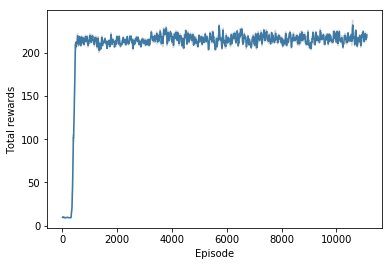

In [45]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

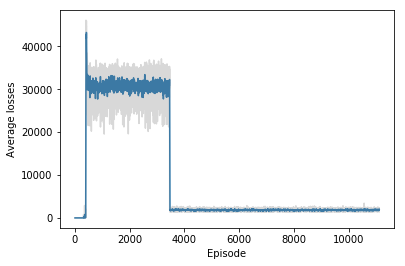

In [46]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.